# JNB2 - Run DFT simulations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import sys

import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import matplotlib.gridspec as gridspec
# import scipy as sci
import scm.plams as scm
from pymatgen.core import Structure

# from ase.visualize import view
# from pymatgen.ext.matproj import MPRester
from pymatgen.io.ase import AseAtomsAdaptor
from scm.plams.interfaces.molecule.ase import fromASE, toASE

from tools import make_dir
from tools.misc import mtx2str

# from shutil import copyfile


matget2ase = AseAtomsAdaptor()

# MPKEY = 'zDsCbuRTjVMusXLvJ54h'
# MAIN_DIR = 'trainset_sim'
# ALLSIM_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA,  'output_all')
# IC_DIR = 'trainset_ic'
# make_dir(MAIN_DIR)
# make_dir(ALLSIM_DIR)
plt.style.use("default")

## Settings

In this section, we define the constants and generators that will be used throughout the notebook:

* `MAIN_DIR_JNB2`: The main folder where the results of this Jupyter Notebook will be stored.
* `CHEM_FORMULA`: The chemical formula of the SEI component.

These constants and generators play a crucial role in ensuring reproducibility and providing the necessary inputs for various computations and simulations in this notebook.

In [3]:
from tools.misc import MAIN_DIR_JNB1, MAIN_DIR_JNB2

CHEM_FORMULA = "LiF"

scm.__version__

'1.5.1'

Making the output folder

In [6]:
make_dir(os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA))

## Unit Cells `Single Point`

In [52]:
SIMsNAME = "0-UnitCell_SP"
TASK = "SP"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

### Setting `BAND` *Single Point*

In [53]:
from tools.misc.default_settings import settings_0_SP

print(settings_0_SP)

input: 	
      AMS: 	
          task: 	SinglePoint
          Properties: 	
                     Gradients: 	yes
                     StressTensor: 	yes
                     Hessian: 	yes
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE
           KSpace: 	
                  Quality: 	Good



### Set-up `RUNNER`

In [54]:
# HPC Job settings
NODES = 2
CORES_PER_NODE = 64
CPUS_PER_CORE = 4
MAX_JOBS = 30

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = r"#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [14]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_0_SP, file)

### Set-up JOBS

Load systems

In [55]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Define jobs

In [20]:
jobs = []
for name, system_obj in systems:
    sim_name = f"SP-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings_0_SP, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

#### Run All

In [ ]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[05.07|14:45:18] JOB jobs STARTED
[05.07|14:45:18] JOB jobs/SP-0-Li2CO3_P6_3mcm_-2.19 STARTED
[05.07|14:45:18] JOB jobs/SP-1-Li2CO3_C2c_-2.26 STARTED
[05.07|15:57:57] JOB jobs/SP-1-Li2CO3_C2c_-2.26 SUCCESSFUL
[05.07|16:02:01] JOB jobs/SP-0-Li2CO3_P6_3mcm_-2.19 SUCCESSFUL
[05.07|16:02:01] JOB jobs SUCCESSFUL


### Post-processing

Load Material Project data

In [56]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0-materialproject")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

In [57]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings_0_SP).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_SP"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom_SP"] = energy_per_atom
results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [58]:
results_df

,energy_per_atom,formation_energy_per_atom,scm_energy_SP,scm_energy_per_atom_SP
0-LiF_Fm-3m_-3.18.cif,-4.845146,-3.180409,-9.622935,-4.811468
1-LiF_P6_3mc_-3.17.cif,-4.838474,-3.173737,-19.208830,-4.802207
2-LiF_Pm-3m_-2.89.cif,-4.557603,-2.892867,-9.023544,-4.511772


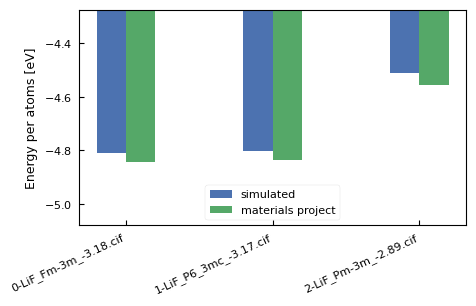

In [59]:
fig = plt.figure(figsize=[5, 2.8], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = fig.add_subplot(111)
    idx = np.arange(len(results_df))
    ax.bar(idx - 0.1, results_df["scm_energy_per_atom_SP"], width=0.20, label="simulated")
    ax.bar(idx + 0.1, results_df["energy_per_atom"], width=0.20, label="materials project")
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks(idx)
    ax.set_xticklabels(results_df.index, rotation=25, ha="right")
    # ax.legend(loc='center left', bbox_to_anchor=(1., 0.5))
    ax.legend(loc="lower center")
    all_E = results_df["energy_per_atom"].values.tolist() + results_df["scm_energy_per_atom_SP"].values.tolist()
    ax.set_ylim(np.min(all_E) - np.abs(np.mean(all_E)) * 0.05, np.max(all_E) + np.abs(np.mean(all_E)) * 0.05)
plt.show()
fig.savefig(os.path.join("plots", f"0-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [22]:
scm.finish()

## Unit Cell `Geometry Optimization`

In [60]:
SIMsNAME = "0-UnitCell_GO"
TASK = "GO"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

### Setting `BAND` *Single Point*

In [61]:
from tools.misc.default_settings import settings_0_GO

print(settings_0_GO)

input: 	
      AMS: 	
          task: 	GeometryOptimization
          Properties: 	
                     Gradients: 	no
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
          GeometryOptimization: 	
                               OptimizeLattice: 	yes
                               PretendConverged: 	yes
                               MaxIterations: 	500
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE
           SCF: 	
               Iterations: 	150
           RadialDefaults: 	
                          NR: 	3000
           CPVector: 	256
           KGRPX: 	10



### Set-up `RUNNER`

In [62]:
NODES = 2
CORES_PER_NODE = 64
CPUS_PER_CORE = 2
MAX_JOBS = 0

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE * NODES
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [8]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_0_GO, file)

### Set-up JOBS

Load systems

In [63]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Define jobs

In [11]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings_0_GO, name=sim_name)
    job.settings.runscript.pre = f"""module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102

export OMP_NUM_THREADS={CPUS_PER_CORE}
export SCM_SHAR_NONUMA=yes
"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

#### Run All

In [13]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[25.12|23:06:46] JOB jobs STARTED
[25.12|23:06:46] JOB jobs/GO-0-C_R-3m_na4 STARTED
[25.12|23:06:46] JOB jobs/GO-1-Li_R-3m_na3 STARTED
[25.12|23:06:46] JOB jobs/GO-2-O_C2m_na8 STARTED
[25.12|23:21:32] JOB jobs/GO-1-Li_R-3m_na3 SUCCESSFUL
[26.12|15:45:03] Job jobs/GO-2-O_C2m_na8 reported warnings. Please check the the output
[26.12|15:45:03] JOB jobs/GO-2-O_C2m_na8 SUCCESSFUL
[26.12|23:13:11] JOB jobs/GO-0-C_R-3m_na4 FAILED
[26.12|23:13:14] JOB jobs FAILED


### Post-processing

Load Material Project data

In [64]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

prev_sim = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, "0-UnitCell_SP")
data_path = os.path.join(prev_sim, f"results.json")
results_df = pd.read_json(data_path)

In [65]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings_0_GO).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_GO"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom_GO"] = energy_per_atom
results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [66]:
results_df

,energy_per_atom,formation_energy_per_atom,scm_energy_SP,scm_energy_per_atom_SP,scm_energy_GO,scm_energy_per_atom_GO
0-LiF_Fm-3m_-3.18.cif,-4.845146,-3.180409,-9.622935,-4.811468,-9.625820,-4.812910
1-LiF_P6_3mc_-3.17.cif,-4.838474,-3.173737,-19.208830,-4.802207,-19.214337,-4.803584
2-LiF_Pm-3m_-2.89.cif,-4.557603,-2.892867,-9.023544,-4.511772,-9.024396,-4.512198


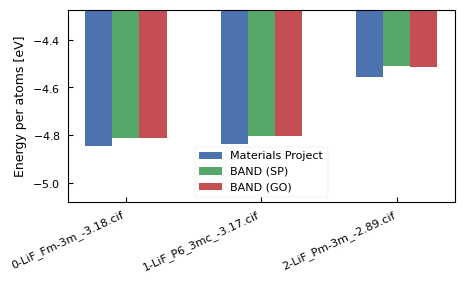

In [67]:
fig = plt.figure(figsize=[5, 2.5], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = fig.add_subplot(111)
    idx = np.arange(len(results_df.index))
    ax.bar(idx - 0.2, results_df["energy_per_atom"], width=0.20, label="Materials Project")
    ax.bar(idx + 0.0, results_df["scm_energy_per_atom_SP"], width=0.20, label="BAND (SP)")
    ax.bar(idx + 0.2, results_df["scm_energy_per_atom_GO"], width=0.20, label="BAND (GO)")
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks(idx)
    ax.set_xticklabels(results_df.index, rotation=25, ha="right")
    # ax.legend(loc='center left', bbox_to_anchor=(1., 0.5))
    ax.legend(loc="lower center")
    all_E = (
        results_df["energy_per_atom"].values.tolist()
        + results_df["scm_energy_per_atom_SP"].values.tolist()
        + results_df["scm_energy_per_atom_GO"].values.tolist()
    )
    ax.set_ylim(np.min(all_E) - np.abs(np.mean(all_E)) * 0.05, np.max(all_E) + np.abs(np.mean(all_E)) * 0.05)

plt.show()
fig.savefig(os.path.join("plots", f"0-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [32]:
scm.finish()

## Pure Species `Single Point`

In [68]:
SIMsNAME = "0.1-PureSpeices_SP"
TASK = "SP"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

#### Setting `BAND` *Single Point*

In [69]:
from tools.misc.default_settings import settings_0_SP

print(settings_0_SP)

input: 	
      AMS: 	
          task: 	SinglePoint
          Properties: 	
                     Gradients: 	yes
                     StressTensor: 	yes
                     Hessian: 	yes
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE
           KSpace: 	
                  Quality: 	Good



#### Set-up `RUNNER`

In [70]:
NODES = 1
CORES_PER_NODE = 128
CPUS_PER_CORE = 2
MAX_JOBS = 0

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [71]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_0_SP, file)

#### Set-up JOBS

Load systems

In [9]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0-materialproject")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

Define jobs

In [11]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings_0_SP, name=sim_name)
    job.settings.runscript.pre = f"""module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102

export OMP_NUM_THREADS={CPUS_PER_CORE}
export SCM_SHAR_NONUMA=yes
"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

#### Run All

In [13]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[25.12|23:06:46] JOB jobs STARTED
[25.12|23:06:46] JOB jobs/GO-0-C_R-3m_na4 STARTED
[25.12|23:06:46] JOB jobs/GO-1-Li_R-3m_na3 STARTED
[25.12|23:06:46] JOB jobs/GO-2-O_C2m_na8 STARTED
[25.12|23:21:32] JOB jobs/GO-1-Li_R-3m_na3 SUCCESSFUL
[26.12|15:45:03] Job jobs/GO-2-O_C2m_na8 reported warnings. Please check the the output
[26.12|15:45:03] JOB jobs/GO-2-O_C2m_na8 SUCCESSFUL
[26.12|23:13:11] JOB jobs/GO-0-C_R-3m_na4 FAILED
[26.12|23:13:14] JOB jobs FAILED


#### Post-processing

Load Material Project data

In [72]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0.1-pure_species")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

In [73]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings_0_SP).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_SP"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom_SP"] = energy_per_atom
results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [74]:
results_df

,energy_per_atom,formation_energy_per_atom,element,N,scm_energy_SP,scm_energy_per_atom_SP
0-F_C2c_na4.cif,-1.911456,0,F,4,-7.119855,-1.779964
1-Li_R-3m_na3.cif,-1.908923,0,Li,3,-5.469886,-1.823295


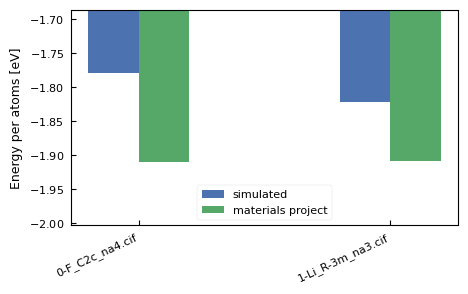

In [75]:
fig = plt.figure(figsize=[5, 2.8], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = fig.add_subplot(111)
    idx = np.arange(len(results_df))
    ax.bar(idx - 0.1, results_df["scm_energy_per_atom_SP"], width=0.20, label="simulated")
    ax.bar(idx + 0.1, results_df["energy_per_atom"], width=0.20, label="materials project")
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks(idx)
    ax.set_xticklabels(results_df.index, rotation=25, ha="right")
    # ax.legend(loc='center left', bbox_to_anchor=(1., 0.5))
    ax.legend(loc="lower center")
    all_E = results_df["energy_per_atom"].values.tolist() + results_df["scm_energy_per_atom_SP"].values.tolist()
    ax.set_ylim(np.min(all_E) - np.abs(np.mean(all_E)) * 0.05, np.max(all_E) + np.abs(np.mean(all_E)) * 0.05)
plt.show()
fig.savefig(os.path.join("plots", f"0.1-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [32]:
scm.finish()

## Pure Species `Geometry Optimization`

In [76]:
SIMsNAME = "0.1-PureSpeices_GO"
TASK = "GO"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

#### Setting `BAND` *Single Point*

In [77]:
from tools.misc.default_settings import settings_0_GO

print(settings_0_GO)

input: 	
      AMS: 	
          task: 	GeometryOptimization
          Properties: 	
                     Gradients: 	no
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
          GeometryOptimization: 	
                               OptimizeLattice: 	yes
                               PretendConverged: 	yes
                               MaxIterations: 	500
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE
           SCF: 	
               Iterations: 	150
           RadialDefaults: 	
                          NR: 	3000
           CPVector: 	256
           KGRPX: 	10



#### Set-up `RUNNER`

In [78]:
NODES = 2
CORES_PER_NODE = 64
CPUS_PER_CORE = 2
MAX_JOBS = 0

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE * NODES
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [79]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_0_GO, file)

#### Set-up JOBS

Load systems

In [80]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0.1-pure_species")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

Define jobs

In [11]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings_0_GO, name=sim_name)
    job.settings.runscript.pre = f"""module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102

export OMP_NUM_THREADS={CPUS_PER_CORE}
export SCM_SHAR_NONUMA=yes
"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

#### Run All

In [13]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[25.12|23:06:46] JOB jobs STARTED
[25.12|23:06:46] JOB jobs/GO-0-C_R-3m_na4 STARTED
[25.12|23:06:46] JOB jobs/GO-1-Li_R-3m_na3 STARTED
[25.12|23:06:46] JOB jobs/GO-2-O_C2m_na8 STARTED
[25.12|23:21:32] JOB jobs/GO-1-Li_R-3m_na3 SUCCESSFUL
[26.12|15:45:03] Job jobs/GO-2-O_C2m_na8 reported warnings. Please check the the output
[26.12|15:45:03] JOB jobs/GO-2-O_C2m_na8 SUCCESSFUL
[26.12|23:13:11] JOB jobs/GO-0-C_R-3m_na4 FAILED
[26.12|23:13:14] JOB jobs FAILED


#### Post-processing

Load Material Project data

In [81]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

prev_sim = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, "0.1-PureSpeices_SP")
data_path = os.path.join(prev_sim, f"results.json")
results_df = pd.read_json(data_path)

In [82]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings_0_GO).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_GO"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom_GO"] = energy_per_atom
results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [83]:
results_df

,energy_per_atom,formation_energy_per_atom,element,N,scm_energy_SP,scm_energy_per_atom_SP,scm_energy_GO,scm_energy_per_atom_GO
0-F_C2c_na4.cif,-1.911456,0,F,4,-7.119855,-1.779964,-7.182324,-1.795581
1-Li_R-3m_na3.cif,-1.908923,0,Li,3,-5.469886,-1.823295,-5.476674,-1.825558


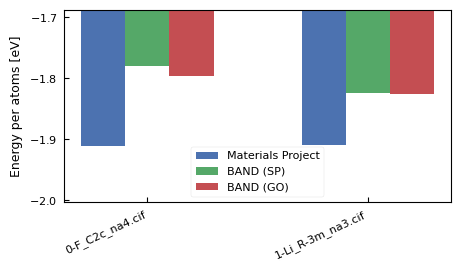

In [84]:
fig = plt.figure(figsize=[5, 2.5], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = fig.add_subplot(111)
    idx = np.arange(len(results_df.index))
    ax.bar(idx - 0.2, results_df["energy_per_atom"], width=0.20, label="Materials Project")
    ax.bar(idx + 0.0, results_df["scm_energy_per_atom_SP"], width=0.20, label="BAND (SP)")
    ax.bar(idx + 0.2, results_df["scm_energy_per_atom_GO"], width=0.20, label="BAND (GO)")
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks(idx)
    ax.set_xticklabels(results_df.index, rotation=25, ha="right")
    # ax.legend(loc='center left', bbox_to_anchor=(1., 0.5))
    ax.legend(loc="lower center")
    all_E = (
        results_df["energy_per_atom"].values.tolist()
        + results_df["scm_energy_per_atom_SP"].values.tolist()
        + results_df["scm_energy_per_atom_GO"].values.tolist()
    )
    ax.set_ylim(np.min(all_E) - np.abs(np.mean(all_E)) * 0.05, np.max(all_E) + np.abs(np.mean(all_E)) * 0.05)

plt.show()
fig.savefig(os.path.join("plots", f"0.1-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [32]:
scm.finish()

## Supercells `Single Point`

In [86]:
SIMsNAME = "1-Supercells_SP"
TASK = "SP"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

#### Setting `BAND` *Single Point*

In [85]:
from tools.misc.default_settings import settings_1_SP

print(settings_1_SP)

input: 	
      AMS: 	
          task: 	SinglePoint
          Properties: 	
                     Gradients: 	yes
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
          GeometryOptimization: 	
                               OptimizeLattice: 	no
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE
           KSpace: 	
                  Quality: 	Good



#### Set-up `RUNNER`

In [87]:
NODES = 2
CORES_PER_NODE = 64
CPUS_PER_CORE = 3
MAX_JOBS = 0

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [88]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_1_SP, file)

### Set-up JOBS

Load systems

In [89]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "1-supercell")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Define jobs

In [33]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings_1_SP, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102

export SCM_SHAR_NONUMA=yes
"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

#### Run All

In [ ]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[05.07|19:49:58] JOB jobs STARTED
[05.07|19:49:58] JOB jobs/SP-1.0-0-Li2CO3_P6_3mcm_-2.19_2x1x1 STARTED
[05.07|19:49:58] JOB jobs/SP-1.0-1-Li2CO3_C2c_-2.26_2x1x1 STARTED
[05.07|19:49:58] JOB jobs/SP-1.1-0-Li2CO3_P6_3mcm_-2.19_2x2x1 STARTED
[05.07|19:49:58] JOB jobs/SP-1.1-1-Li2CO3_C2c_-2.26_2x2x1 STARTED
[05.07|19:49:58] JOB jobs/SP-1.2-0-Li2CO3_P6_3mcm_-2.19_2x2x2 STARTED
[05.07|19:49:58] JOB jobs/SP-1.2-1-Li2CO3_C2c_-2.26_2x2x2 STARTED
[05.07|19:49:58] JOB jobs/SP-1.3-0-Li2CO3_P6_3mcm_-2.19_3x2x2 STARTED
[05.07|19:49:58] JOB jobs/SP-1.3-1-Li2CO3_C2c_-2.26_3x2x2 STARTED
[05.07|19:49:58] JOB jobs/SP-1.4-0-Li2CO3_P6_3mcm_-2.19_3x3x2 STARTED
[05.07|19:49:58] JOB jobs/SP-1.4-1-Li2CO3_C2c_-2.26_3x3x2 STARTED
[05.07|19:49:58] JOB jobs/SP-1.5-0-Li2CO3_P6_3mcm_-2.19_3x3x3 STARTED
[05.07|19:49:58] JOB jobs/SP-1.5-1-Li2CO3_C2c_-2.26_3x3x3 STARTED
[05.07|19:55:26] JOB jobs/SP-1.0-0-Li2CO3_P6_3mcm_-2.19_2x1x1 SUCCESSFUL
[05.07|19:56:21] JOB jobs/SP-1.0-1-Li2CO3_C2c_-2.26_2x1x1 SUCCESSFUL
[05.07|2

### Post-processing

Load crystel data

In [105]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "1-supercell")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

In [106]:
results_df.head()

,unitcell_repetition
1.0-0-LiF_Fm-3m_-3.18_2x1x1.cif,2
1.0-1-LiF_P6_3mc_-3.17_2x1x1.cif,2
1.0-2-LiF_Pm-3m_-2.89_2x1x1.cif,2
1.1-0-LiF_Fm-3m_-3.18_2x2x1.cif,4
1.1-1-LiF_P6_3mc_-3.17_2x2x1.cif,4


In [111]:
crystal_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0-materialproject")
data_path = os.path.join(crystal_dir, "info.json")
crystals_df = pd.read_json(data_path)

for job_dir in np.sort(glob.glob(os.path.join(dir_jobs, "*"))):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings_1_SP).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "energy_SP"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "energy_per_atom_SP"] = energy_per_atom

results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [112]:
results_df.head()

,unitcell_repetition,energy_SP,energy_per_atom_SP
1.0-0-LiF_Fm-3m_-3.18_2x1x1.cif,2,-19.251315,-4.812829
1.0-1-LiF_P6_3mc_-3.17_2x1x1.cif,2,-38.292625,-4.786578
1.0-2-LiF_Pm-3m_-2.89_2x1x1.cif,2,-18.076721,-4.519180
1.1-0-LiF_Fm-3m_-3.18_2x2x1.cif,4,-38.502611,-4.812826
1.1-1-LiF_P6_3mc_-3.17_2x2x1.cif,4,-76.653339,-4.790834


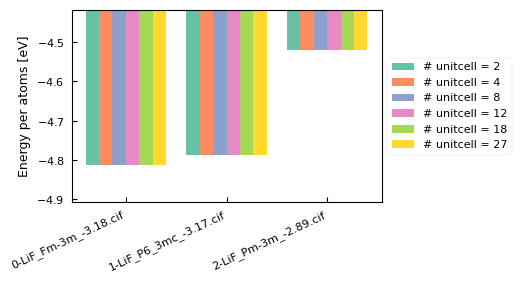

In [128]:
fig = plt.figure(figsize=[4, 2.5])
n_sc = len(results_df["unitcell_repetition"].unique())
idx = np.arange(len(crystals_df))

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = fig.add_subplot(111)
    Set2 = mp.colormaps["Set2"]
    for j, n_uc in enumerate(results_df["unitcell_repetition"].unique().tolist()):
        ax.bar([np.nan], [np.nan], width=0.8 / n_sc, label=f"# unitcell = {n_uc}", color=Set2.colors[j])
        sub_set = results_df.loc[results_df["unitcell_repetition"] == n_uc, :]
        for i, name in enumerate(sub_set.index):
            ax.bar(
                i + 0.8 * (j + 0.5) / n_sc - 0.4,
                results_df["energy_per_atom_SP"][i],
                width=0.8 / n_sc,
                color=Set2.colors[j],
            )
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks(idx)
    ax.set_xticklabels(crystals_df.index, rotation=25, ha="right")
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    all_E = results_df["energy_per_atom_SP"].values.tolist()
    ax.set_ylim(np.min(all_E) - np.abs(np.mean(all_E)) * 0.02, np.max(all_E) + np.abs(np.mean(all_E)) * 0.02)

plt.show()
fig.savefig(os.path.join("plots", f"1-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [40]:
scm.finish()

## Supercells `Geometry Optimization`

In [191]:
SIMsNAME = "1-Supercells_GO"
TASK = "GO"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

### Setting `BAND` *Single Point*

In [192]:
from tools.misc.default_settings import settings_1_GO

print(settings_1_GO)

input: 	
      AMS: 	
          task: 	GeometryOptimization
          Properties: 	
                     Gradients: 	yes
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
          GeometryOptimization: 	
                               OptimizeLattice: 	no
                               PretendConverged: 	yes
                               MaxIterations: 	150
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE
           KSpace: 	
                  Quality: 	Good



### Set-up `RUNNER`

In [193]:
NODES = 2
CORES_PER_NODE = 64
CPUS_PER_CORE = 2
MAX_JOBS = 64

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [142]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_1_GO, file)

### Set-up JOBS

Load systems

In [143]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "1-supercell")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Define jobs

In [47]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings_1_GO, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

### Run All

In [ ]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[05.07|21:50:03] JOB jobs STARTED
[05.07|21:50:03] JOB jobs/GO-1.0-0-Li2CO3_P6_3mcm_-2.19_2x1x1 STARTED
[05.07|21:50:03] JOB jobs/GO-1.0-1-Li2CO3_C2c_-2.26_2x1x1 STARTED
[05.07|21:50:03] JOB jobs/GO-1.1-0-Li2CO3_P6_3mcm_-2.19_2x2x1 STARTED
[05.07|21:50:03] JOB jobs/GO-1.1-1-Li2CO3_C2c_-2.26_2x2x1 STARTED
[05.07|21:50:03] JOB jobs/GO-1.2-0-Li2CO3_P6_3mcm_-2.19_2x2x2 STARTED
[05.07|21:50:03] JOB jobs/GO-1.2-1-Li2CO3_C2c_-2.26_2x2x2 STARTED
[05.07|21:50:03] JOB jobs/GO-1.3-0-Li2CO3_P6_3mcm_-2.19_3x2x2 STARTED
[05.07|21:50:03] JOB jobs/GO-1.3-1-Li2CO3_C2c_-2.26_3x2x2 STARTED
[05.07|21:50:03] JOB jobs/GO-1.4-0-Li2CO3_P6_3mcm_-2.19_3x3x2 STARTED
[05.07|21:50:03] JOB jobs/GO-1.4-1-Li2CO3_C2c_-2.26_3x3x2 STARTED
[05.07|21:50:03] JOB jobs/GO-1.5-0-Li2CO3_P6_3mcm_-2.19_3x3x3 STARTED
[05.07|21:50:03] JOB jobs/GO-1.5-1-Li2CO3_C2c_-2.26_3x3x3 STARTED
[05.07|21:53:26] JOB jobs/GO-1.0-0-Li2CO3_P6_3mcm_-2.19_2x1x1 SUCCESSFUL
[05.07|21:54:40] JOB jobs/GO-1.0-1-Li2CO3_C2c_-2.26_2x1x1 SUCCESSFUL
[05.07|2

### Post-processing

Load crystel data

In [194]:
dir_jobs = os.path.join(RUN_DIR, "jobs")
prev_sim = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, "1-Supercells_SP")
data_path = os.path.join(prev_sim, "results.json")
results_df = pd.read_json(data_path)

In [195]:
results_df.head()

,unitcell_repetition,energy_SP,energy_per_atom_SP,energy_GO,energy_per_atom_GO
1.0-0-LiF_Fm-3m_-3.18_2x1x1.cif,2,-19.251315,-4.812829,-19.251315,-4.812829
1.0-1-LiF_P6_3mc_-3.17_2x1x1.cif,2,-38.292625,-4.786578,-38.292625,-4.786578
1.0-2-LiF_Pm-3m_-2.89_2x1x1.cif,2,-18.076721,-4.519180,-18.076721,-4.519180
1.1-0-LiF_Fm-3m_-3.18_2x2x1.cif,4,-38.502611,-4.812826,-38.502611,-4.812826
1.1-1-LiF_P6_3mc_-3.17_2x2x1.cif,4,-76.653339,-4.790834,-76.653339,-4.790834


In [196]:
crystal_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "0-materialproject")
data_path = os.path.join(crystal_dir, "info.json")
crystals_df = pd.read_json(data_path)

for job_dir in np.sort(glob.glob(os.path.join(dir_jobs, "*"))):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings_1_GO).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "energy_GO"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "energy_per_atom_GO"] = energy_per_atom

results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [197]:
results_df.head()

,unitcell_repetition,energy_SP,energy_per_atom_SP,energy_GO,energy_per_atom_GO
1.0-0-LiF_Fm-3m_-3.18_2x1x1.cif,2,-19.251315,-4.812829,-19.053002,-4.763251
1.0-1-LiF_P6_3mc_-3.17_2x1x1.cif,2,-38.292625,-4.786578,-38.003627,-4.750453
1.0-2-LiF_Pm-3m_-2.89_2x1x1.cif,2,-18.076721,-4.519180,-17.868644,-4.467161
1.1-0-LiF_Fm-3m_-3.18_2x2x1.cif,4,-38.502611,-4.812826,-38.105975,-4.763247
1.1-1-LiF_P6_3mc_-3.17_2x2x1.cif,4,-76.653339,-4.790834,-76.077089,-4.754818


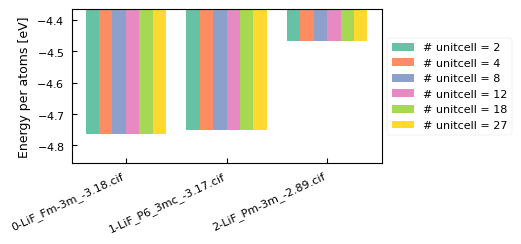

In [198]:
fig = plt.figure(figsize=[4, 2])
n_sc = len(results_df["unitcell_repetition"].unique())
idx = np.arange(len(crystals_df))

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = fig.add_subplot(111)
    Set2 = mp.colormaps["Set2"]
    for j, n_uc in enumerate(results_df["unitcell_repetition"].unique().tolist()):
        ax.bar([np.nan], [np.nan], width=0.8 / n_sc, label=f"# unitcell = {n_uc}", color=Set2.colors[j])
        sub_set = results_df.loc[results_df["unitcell_repetition"] == n_uc, :]
        for i, name in enumerate(sub_set.index):
            ax.bar(
                i + 0.8 * (j + 0.5) / n_sc - 0.4,
                results_df["energy_per_atom_GO"][i],
                width=0.8 / n_sc,
                color=Set2.colors[j],
            )
    ax.set_ylabel("Energy per atoms [eV]")
    ax.set_xticks(idx)
    ax.set_xticklabels(crystals_df.index, rotation=25, ha="right")
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    all_E = results_df["energy_per_atom_GO"].values.tolist()
    ax.set_ylim(np.min(all_E) - np.abs(np.mean(all_E)) * 0.02, np.max(all_E) + np.abs(np.mean(all_E)) * 0.02)

plt.show()
fig.savefig(os.path.join("plots", f"1-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [54]:
scm.finish()

## Strain `Single Poin`

In [199]:
SIMsNAME = "2-Strain_SP"
TASK = "SP"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

### Setting `BAND` *Single Point*

In [200]:
from tools.misc.default_settings import settings_2_SP

print(settings_2_SP)

input: 	
      AMS: 	
          task: 	SinglePoint
          Properties: 	
                     Gradients: 	yes
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE



### Set-up `RUNNER`

In [201]:
NODES = 2
CORES_PER_NODE = 32
CPUS_PER_CORE = 4
MAX_JOBS = 64

In [202]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="
RUNNER.settings.special.cpu_freq = "--cpu-freq="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE * NODES
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[19.06|00:41:10] PLAMS working folder: /home/paolo/Enhancing_ReaxFF/step02-sim/LiF/2-Strain_SP.002


In [203]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_2_SP, file)

### Set-up JOBS

Load systems

In [204]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "2-strain")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Define jobs

In [ ]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job_dir = os.path.join(RUN_DIR, "jobs", sim_name)
    if os.path.exists(job_dir):
        job = scm.AMSJob.load_external(job_dir, settings=settings_2_SP)
        if not job.check():
            print(f"sim {sim_name} FAILE will rerun it")
        else:
            continue
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = f"""module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102

export OMP_NUM_THREADS={CPUS_PER_CORE}
export SCM_SHAR_NONUMA=yes
"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

#### Run All

In [ ]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
    cpu_freq=2250000,
)

### Post-processing

Load Material Project data

In [205]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "2-strain")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

In [214]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings_2_SP)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    mol = toASE(job_result.get_molecule("Molecule"))
    Na = len(mol)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    strain_mtx = results_df.loc[sim_name[3:] + ".cif", "strain_matrix"]
    simple_str, latex_str = mtx2str(strain_mtx)
    results_df.loc[sim_name[3:] + ".cif", "strain_str"] = simple_str
    results_df.loc[sim_name[3:] + ".cif", "strain_str_latex"] = latex_str
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    strain_mtx = np.array(strain_mtx)
    strain_mtx_sq = np.power(strain_mtx, 2)
    von_mises_strain = (
        2
        / 3
        * np.sign(strain_mtx.sum())
        * np.power(
            3 / 2 * np.sum((strain_mtx - 1 / 3 * strain_mtx.diagonal(0).sum() * np.eye(3)).sum(axis=0) ** 2)
            + 3 / 4 * np.sum(np.tril(2 * strain_mtx, -1) ** 2),
            1 / 2,
        )
    )
    results_df.loc[sim_name[3:] + ".cif", "von_mises_strain"] = von_mises_strain
    results_df.loc[sim_name[3:] + ".cif", "vol"] = mol.get_volume()
results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [215]:
results_df

,unitcell_repetition,strain_matrix,scm_energy,scm_energy_per_atom,strain_str,strain_str_latex,system_id,von_mises_strain,vol
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif,8,"[[-0.125, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....",-75.961595,-4.747600,e_11,$\varepsilon_{ 1 1 }$,0.0,-8.333333e-02,117.932997
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif,8,"[[-0.095, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....",-76.494122,-4.780883,e_11,$\varepsilon_{ 1 1 }$,0.0,-6.333333e-02,122.559565
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif,8,"[[-0.065, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....",-76.823927,-4.801495,e_11,$\varepsilon_{ 1 1 }$,0.0,-4.333333e-02,127.017725
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif,8,"[[-0.035, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....",-76.981781,-4.811361,e_11,$\varepsilon_{ 1 1 }$,0.0,-2.333333e-02,131.324627
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif,8,"[[-0.005, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....",-77.010916,-4.813182,e_11,$\varepsilon_{ 1 1 }$,0.0,-3.333333e-03,135.494698
...,...,...,...,...,...,...,...,...,...
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif,8,"[[0.115, 0.0, 0.0], [0.0, 0.115, 0.0], [0.0, 0...",-69.102913,-4.318932,e_11 e_22 e_33,$\varepsilon_{ 1 1 } \varepsilon_{ 2 2 } \vare...,2.0,0.000000e+00,182.991053
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif,8,"[[0.145, 0.0, 0.0], [0.0, 0.145, 0.0], [0.0, 0...",-68.165433,-4.260340,e_11 e_22 e_33,$\varepsilon_{ 1 1 } \varepsilon_{ 2 2 } \vare...,2.0,3.925231e-17,196.542625
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif,8,"[[0.17500000000000002, 0.0, 0.0], [0.0, 0.1750...",-67.159394,-4.197462,e_11 e_22 e_33,$\varepsilon_{ 1 1 } \varepsilon_{ 2 2 } \vare...,2.0,3.925231e-17,210.413131
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif,8,"[[0.20500000000000002, 0.0, 0.0], [0.0, 0.2050...",-66.106027,-4.131627,e_11 e_22 e_33,$\varepsilon_{ 1 1 } \varepsilon_{ 2 2 } \vare...,2.0,3.925231e-17,224.595400


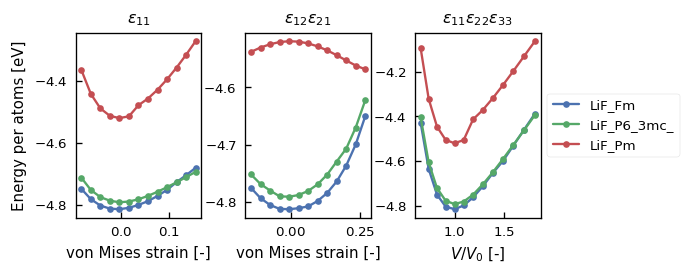

In [218]:
fig = plt.figure(figsize=[5, 2], dpi=120)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = {}
    strain_strs = results_df["strain_str"].dropna().unique()
    strain_strs_latex = results_df["strain_str_latex"].dropna().unique()
    spec = fig.add_gridspec(1, len(strain_strs), wspace=0.35)
    for i, (strain_str, strain_str_latex) in enumerate(zip(strain_strs, strain_strs_latex)):
        ax[i] = fig.add_subplot(spec[i])
        ax[i].set_title(strain_str_latex)
        sub_df = results_df.loc[results_df["strain_str"] == strain_str].dropna()
        for sim_id in results_df["system_id"].dropna().unique():
            idx = np.arange(len(results_df.index))
            sub_sub_df = sub_df.loc[sub_df["system_id"] == sim_id]
            name = sub_sub_df.index[0].split("-")[2]
            if strain_str == "e_11 e_22 e_33":
                min_ind = np.where(sub_sub_df["scm_energy_per_atom"] == sub_sub_df["scm_energy_per_atom"].min())
                ax[i].plot(
                    sub_sub_df["vol"] / sub_sub_df["vol"].values[min_ind],
                    sub_sub_df["scm_energy_per_atom"],
                    "o-",
                    label=name,
                )
            else:
                ax[i].plot(sub_sub_df["von_mises_strain"], sub_sub_df["scm_energy_per_atom"], "o-", label=name)
        if strain_str == "e_11 e_22 e_33":
            ax[i].set_xlabel("$V/V_0$ [-]")
        else:
            ax[i].set_xlabel("von Mises strain [-]")

    ax[len(strain_strs) - 1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    ax[0].set_ylabel("Energy per atoms [eV]")
plt.show()
fig.savefig(os.path.join("plots", f"2-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

Finishing

In [ ]:
scm.finish()

## Vacancies `Single Poin`

In [48]:
SIMsNAME = "3-Vacancies_SP"
TASK = "SP"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

### Setting `BAND` *Single Point*

In [49]:
from tools.misc.default_settings import settings_3_SP

print(settings_3_SP)

input: 	
      AMS: 	
          task: 	SinglePoint
          Properties: 	
                     Gradients: 	yes
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE



### Set-up `RUNNER`

In [18]:
NODES = 4
CORES_PER_NODE = 32
CPUS_PER_CORE = 4
MAX_JOBS = 64

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [6]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_3_SP, file)

### Set-up JOBS

Load systems

In [10]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "3-vacancies")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Define jobs

In [22]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job_dir = os.path.join(RUN_DIR, "jobs", sim_name)
    if os.path.exists(job_dir):
        job = scm.AMSJob.load_external(job_dir, settings=settings)
        if not job.check():
            print(f"sim {sim_name} FAILE will rerun it")
        else:
            continue
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = f"""module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102
export OMP_NUM_THREADS={CPUS_PER_CORE}
"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

### Run All

In [24]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[10:33:40] JOB jobs STARTED
[10:33:40] JOB jobs/SP-3.0-0-LiF_Fm-3m_-3.18_nv_1 STARTED
[10:33:40] JOB jobs/SP-3.0-1-LiF_P6_3mc_-3.17_nv_1 STARTED
[10:33:40] JOB jobs/SP-3.0-2-LiF_Pm-3m_-2.89_nv_1 STARTED
[10:33:40] JOB jobs/SP-3.1-0-LiF_Fm-3m_-3.18_nv_1 STARTED
[10:33:40] JOB jobs/SP-3.1-1-LiF_P6_3mc_-3.17_nv_1 STARTED
[10:33:40] JOB jobs/SP-3.1-2-LiF_Pm-3m_-2.89_nv_1 STARTED
[10:33:40] JOB jobs/SP-3.10-1-LiF_P6_3mc_-3.17_nv_4 STARTED
[10:33:40] JOB jobs/SP-3.11-1-LiF_P6_3mc_-3.17_nv_4 STARTED
[10:33:40] JOB jobs/SP-3.12-1-LiF_P6_3mc_-3.17_nv_4 STARTED
[10:33:40] JOB jobs/SP-3.13-1-LiF_P6_3mc_-3.17_nv_4 STARTED
[10:33:40] JOB jobs/SP-3.14-1-LiF_P6_3mc_-3.17_nv_5 STARTED
[10:33:40] JOB jobs/SP-3.15-1-LiF_P6_3mc_-3.17_nv_5 STARTED
[10:33:40] JOB jobs/SP-3.16-1-LiF_P6_3mc_-3.17_nv_5 STARTED
[10:33:40] JOB jobs/SP-3.17-1-LiF_P6_3mc_-3.17_nv_5 STARTED
[10:33:40] JOB jobs/SP-3.2-0-LiF_Fm-3m_-3.18_nv_2 STARTED
[10:33:40] JOB jobs/SP-3.2-1-LiF_P6_3mc_-3.17_nv_2 STARTED
[10:33:40] JOB jobs/SP-3.

### Post-processing

In [50]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "3-vacancies")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

In [51]:
results_df.head()

,vacancy_site,vacancy_element,unitcell_repetition
3.0-0-LiF_Fm-3m_-3.18_nv_1.cif,"[[0.0, 0.0, 0.0]]",[Li],4
3.1-0-LiF_Fm-3m_-3.18_nv_1.cif,"[[1.6670525006, 1.1787841278, 2.88741963]]",[F],4
3.2-0-LiF_Fm-3m_-3.18_nv_2.cif,"[[1.6670525006, 1.1787841278, 2.88741963], [0....","[F, Li]",4
3.3-0-LiF_Fm-3m_-3.18_nv_2.cif,"[[1.6670525006, 1.1787841278, 2.88741963], [2....","[F, F]",4
3.4-0-LiF_Fm-3m_-3.18_nv_3.cif,"[[1.6670525006, 1.1787841278, 2.88741963], [0....","[F, Li, Li]",4


In [52]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings_3_SP)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])

results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [53]:
results_df.head()

,vacancy_site,vacancy_element,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id
3.0-0-LiF_Fm-3m_-3.18_nv_1.cif,"[[0.0, 0.0, 0.0]]",[Li],4.0,-250.853627,-4.733087,0.0
3.1-0-LiF_Fm-3m_-3.18_nv_1.cif,"[[1.6670525006, 1.1787841278, 2.88741963]]",[F],4.0,-250.588127,-4.728078,0.0
3.2-0-LiF_Fm-3m_-3.18_nv_2.cif,"[[1.6670525006, 1.1787841278, 2.88741963], [0....","[F, Li]",4.0,-246.515831,-4.740689,0.0
3.3-0-LiF_Fm-3m_-3.18_nv_2.cif,"[[1.6670525006, 1.1787841278, 2.88741963], [2....","[F, F]",4.0,-242.263743,-4.658918,0.0
3.4-0-LiF_Fm-3m_-3.18_nv_3.cif,"[[1.6670525006, 1.1787841278, 2.88741963], [0....","[F, Li, Li]",4.0,-238.689686,-4.680190,0.0


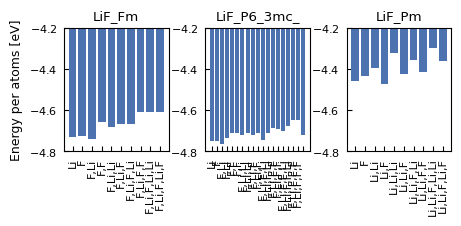

In [55]:
fig = plt.figure(figsize=[5, 1.6], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = {}
    system_id = results_df["system_id"].unique()
    spec = fig.add_gridspec(1, len(system_id), wspace=0.35)
    for i, sim_id in enumerate(results_df["system_id"].unique()):
        ax[i] = fig.add_subplot(spec[i])
        idx = np.arange(len(results_df.index))
        sub_df = results_df.loc[results_df["system_id"] == sim_id]
        xticks = np.arange(len(sub_df))
        name = sub_df.index[0].split("-")[2]
        ax[i].bar(xticks, sub_df["scm_energy_per_atom"], label=name)
        ax[i].set_ylim([-4.8, -4.2])
        ax[i].set_xticks(xticks)
        xticks_labels = [",".join(sites) if sites == sites else "" for sites in sub_df["vacancy_element"]]
        ax[i].set_xticklabels(xticks_labels, rotation=90, ha="center")
        ax[i].set_title(name)
    ax[0].set_ylabel("Energy per atoms [eV]")
plt.show()
fig.savefig(os.path.join("plots", f"3-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [ ]:
scm.finish()

## Substitution `Single Poin`

In [56]:
SIMsNAME = "4-Substitution_SP"
TASK = "SP"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

### Setting `BAND` *Single Point*

In [57]:
from tools.misc.default_settings import settings_4_SP

print(settings_4_SP)

input: 	
      AMS: 	
          task: 	SinglePoint
          Properties: 	
                     Gradients: 	yes
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE



### Set-up `RUNNER`

In [30]:
NODES = 4
CORES_PER_NODE = 8
CPUS_PER_CORE = 4
MAX_JOBS = 64

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

In [31]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_4_SP, file)

#### Set-up JOBS

Load systems

In [32]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "4-substitutions")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

Define jobs

In [29]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings_4_SP, name=sim_name)
    job.settings.runscript.pre = f"""module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102
export OMP_NUM_THREADS={CPUS_PER_CORE}
"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

#### Run All

In [32]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[18:57:04] JOB jobs STARTED
[18:57:04] JOB jobs/SP-4.0-0-LiF_Fm-3m_-3.18_ns_1 STARTED
[18:57:04] JOB jobs/SP-4.0-1-LiF_P6_3mc_-3.17_ns_1 STARTED
[18:57:04] JOB jobs/SP-4.0-2-LiF_Pm-3m_-2.89_ns_1 STARTED
[18:57:04] JOB jobs/SP-4.1-0-LiF_Fm-3m_-3.18_ns_2 STARTED
[18:57:04] JOB jobs/SP-4.1-1-LiF_P6_3mc_-3.17_ns_2 STARTED
[18:57:04] JOB jobs/SP-4.1-2-LiF_Pm-3m_-2.89_ns_2 STARTED
[18:57:04] JOB jobs/SP-4.2-0-LiF_Fm-3m_-3.18_ns_3 STARTED
[18:57:04] JOB jobs/SP-4.2-1-LiF_P6_3mc_-3.17_ns_3 STARTED
[18:57:04] JOB jobs/SP-4.2-2-LiF_Pm-3m_-2.89_ns_3 STARTED
[18:57:04] JOB jobs/SP-4.3-0-LiF_Fm-3m_-3.18_ns_4 STARTED
[18:57:04] JOB jobs/SP-4.3-1-LiF_P6_3mc_-3.17_ns_4 STARTED
[18:57:04] JOB jobs/SP-4.3-2-LiF_Pm-3m_-2.89_ns_4 STARTED
[18:57:04] JOB jobs/SP-4.4-0-LiF_Fm-3m_-3.18_ns_5 STARTED
[18:57:04] JOB jobs/SP-4.4-1-LiF_P6_3mc_-3.17_ns_5 STARTED
[18:57:04] JOB jobs/SP-4.4-2-LiF_Pm-3m_-2.89_ns_5 STARTED


### Post-processing

Load Material Project data

In [58]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "4-substitutions")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [59]:
results_df.head()

,substitution_site,substitution_element,unitcell_repetition
4.0-0-LiF_Fm-3m_-3.18_ns_1.cif,"[[0.0, 0.0, 0.0]]",[F],4
4.1-0-LiF_Fm-3m_-3.18_ns_2.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F]",4
4.2-0-LiF_Fm-3m_-3.18_ns_3.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F, Li]",4
4.3-0-LiF_Fm-3m_-3.18_ns_4.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F, Li, F]",4
4.4-0-LiF_Fm-3m_-3.18_ns_5.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F, Li, F, F]",4


In [60]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings_4_SP).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])

results_df.to_json(os.path.join(RUN_DIR, f"results.json"))

In [61]:
results_df.head()

,substitution_site,substitution_element,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id
4.0-0-LiF_Fm-3m_-3.18_ns_1.cif,"[[0.0, 0.0, 0.0]]",[F],4,-246.959376,-4.573322,0.0
4.1-0-LiF_Fm-3m_-3.18_ns_2.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F]",4,-233.970146,-4.332780,0.0
4.2-0-LiF_Fm-3m_-3.18_ns_3.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F, Li]",4,-223.081439,-4.131138,0.0
4.3-0-LiF_Fm-3m_-3.18_ns_4.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F, Li, F]",4,-212.037549,-3.926621,0.0
4.4-0-LiF_Fm-3m_-3.18_ns_5.cif,"[[0.0, 0.0, 0.0], [0.8335262503, 2.3575682556,...","[F, F, Li, F, F]",4,-200.977492,-3.721805,0.0


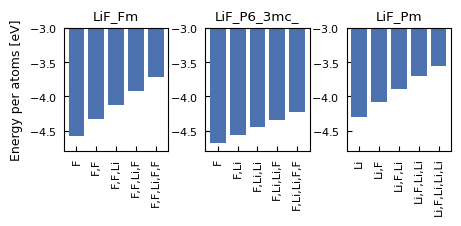

In [62]:
fig = plt.figure(figsize=[5, 1.6], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = {}
    system_id = results_df["system_id"].unique()
    system_id = [id for id in system_id if id == id]
    spec = fig.add_gridspec(1, len(system_id), wspace=0.35)
    for i, sim_id in enumerate(system_id):
        ax[i] = fig.add_subplot(spec[i])
        idx = np.arange(len(results_df.index))
        sub_df = results_df.loc[results_df["system_id"] == sim_id]
        xticks = np.arange(len(sub_df))
        name = sub_df.index[0].split("-")[2]
        ax[i].bar(xticks, sub_df["scm_energy_per_atom"], label=name)
        ax[i].set_ylim([-4.8, -3])
        ax[i].set_xticks(xticks)
        xticks_labels = [",".join(sites) if sites == sites else "" for sites in sub_df["substitution_element"]]
        ax[i].set_xticklabels(xticks_labels, rotation=90, ha="center")
        ax[i].set_title(name)
    ax[0].set_ylabel("Energy per atoms [eV]")
plt.show()
fig.savefig(os.path.join("plots", f"4-{CHEM_FORMULA}_{TASK}_sim_energy.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [160]:
scm.finish()

## Interstitial `Pre Optimization`

In [4]:
SIMsNAME = "5-Interstitial_PreO"
TASK = "PreO"
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)

#### Setting `BAND` *Geopmetry Optimization*

In [63]:
from tools.misc.default_settings import settings_0_GO

print(settings_0_GO)

input: 	
      AMS: 	
          task: 	GeometryOptimization
          Properties: 	
                     Gradients: 	no
                     StressTensor: 	no
                     Hessian: 	no
                     PESPointCharacter: 	no
                     ElasticTensor: 	no
          GeometryOptimization: 	
                               OptimizeLattice: 	yes
                               PretendConverged: 	yes
                               MaxIterations: 	500
      BAND: 	
           basis: 	
                 type: 	DZP
           xc: 	
              GGA: 	PBE
           SCF: 	
               Iterations: 	150
           RadialDefaults: 	
                          NR: 	3000
           CPVector: 	256
           KGRPX: 	10



#### Set-up `RUNNER`

In [64]:
NODES = 1
CORES_PER_NODE = 64
CPUS_PER_CORE = 4
MAX_JOBS = 15

In [7]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings_0_GO, file)

In [ ]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE * NODES
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

#### Set-up JOBS

Load systems

In [66]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "5-interstitial")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/home/paolo/Enhancing_ReaxFF/venv/lib/python3.8/site-packages/pymatgen/io/cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Define jobs

In [182]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [183]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [184]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[26.11|20:46:50] JOB jobs STARTED
[26.11|20:46:50] JOB jobs/PO-5.0-0-LiF_Fm-3m_-3.18_ni_0 STARTED
[26.11|20:46:50] JOB jobs/PO-5.0-1-LiF_P6_3mc_-3.17_ni_0 STARTED
[26.11|20:46:50] JOB jobs/PO-5.0-2-LiF_Pm-3m_-2.89_ni_0 STARTED
[26.11|20:46:50] JOB jobs/PO-5.1-0-LiF_Fm-3m_-3.18_ni_1 STARTED
[26.11|20:46:50] JOB jobs/PO-5.1-1-LiF_P6_3mc_-3.17_ni_1 STARTED
[26.11|20:46:50] JOB jobs/PO-5.1-2-LiF_Pm-3m_-2.89_ni_1 STARTED
[26.11|20:46:50] JOB jobs/PO-5.2-0-LiF_Fm-3m_-3.18_ni_2 STARTED
[26.11|20:46:50] JOB jobs/PO-5.2-1-LiF_P6_3mc_-3.17_ni_2 STARTED
[26.11|20:46:50] JOB jobs/PO-5.2-2-LiF_Pm-3m_-2.89_ni_2 STARTED
[26.11|20:46:50] JOB jobs/PO-5.3-0-LiF_Fm-3m_-3.18_ni_3 STARTED
[26.11|20:46:50] JOB jobs/PO-5.3-1-LiF_P6_3mc_-3.17_ni_3 STARTED
[26.11|20:46:50] JOB jobs/PO-5.3-2-LiF_Pm-3m_-2.89_ni_3 STARTED
[26.11|20:46:50] JOB jobs/PO-5.4-0-LiF_Fm-3m_-3.18_ni_4 STARTED
[26.11|20:46:50] JOB jobs/PO-5.4-1-LiF_P6_3mc_-3.17_ni_4 STARTED
[26.11|20:46:50] JOB jobs/PO-5.4-2-LiF_Pm-3m_-2.89_ni_4 STARTED
[

trainset_sim/5-Interstitial_GO_2/jobs/GO-5.1-0-LiF_Fm-3m_-3.18_ni_1/ams.log


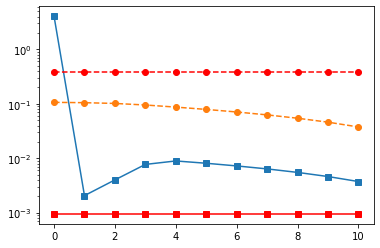

[01.12|19:36:05] Job jobs/GO-5.2-2-LiF_Pm-3m_-2.89_ni_2 reported warnings. Please check the the output
[01.12|19:36:05] JOB jobs/GO-5.2-2-LiF_Pm-3m_-2.89_ni_2 SUCCESSFUL


In [163]:
name = systems[3][0]
file = f"trainset_sim/5-Interstitial_GO_2/jobs/GO-{name}/ams.log"
print(file)
grandient = []
energy = []
grandient_t = []
energy_t = []
with open(file) as f:
    for line in f:
        # print(line)
        if "constrained gradient max" in line:
            grandient.append(abs(float(line.split()[-3])))
            grandient_t.append(abs(float(line.split()[-2])))
        if "energy change" in line:
            # print(line)
            energy.append(abs(float(line.split()[-3])))
            energy_t.append(abs(float(line.split()[-2])))

start_i = 0
plt.semilogy(energy[start_i:], "s-")
plt.semilogy(energy_t[start_i:], "s-r")
plt.semilogy(grandient[start_i:], "o--")
plt.semilogy(grandient_t[start_i:], "o--r")

#### Post-processing

Move to end folder

In [7]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Save last configuration

In [10]:
conf_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "5.1-interstitial_PO")
make_dir(conf_dir)

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    name = sim_name[3:]
    mol = job.results.get_input_molecule()
    # print(os.path.join(conf_dir, f'{name}.cif'))
    mol = SCMtoASE(mol)
    mol.write(os.path.join(conf_dir, f"{name}.cif"), format="cif")

Post Processing

Load Material Project data

In [11]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "5-interstitial")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [12]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job_result = scm.AMSJob.load_external(job_dir, settings=settings).results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_PO_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_PO_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])

results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))
results_df.to_json(os.path.join(conf_dir, "info.json"))

In [13]:
results_df.head()

,unitcell_repetition,interstitial_site,interstitial_element,scm_PO_energy,scm_PO_energy_per_atom,system_id
5.0-0-LiF_Fm-3m_-3.18_ni_0.cif,12,[],[],-122.520549,-5.105023,0.0
5.1-0-LiF_Fm-3m_-3.18_ni_1.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926]]",[Li],-119.788653,-4.791546,0.0
5.2-0-LiF_Fm-3m_-3.18_ni_2.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926], [3....","[Li, Li]",-121.977475,-4.691441,0.0
5.3-0-LiF_Fm-3m_-3.18_ni_3.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926], [3....","[Li, Li, Li]",-121.142548,-4.486761,0.0
5.4-0-LiF_Fm-3m_-3.18_ni_4.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926], [3....","[Li, Li, Li, Li]",-121.414971,-4.336249,0.0


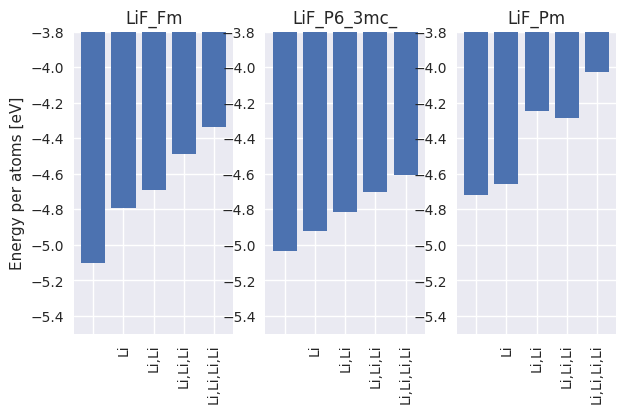

In [15]:
fig = plt.figure(figsize=[7, 4], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = {}
    system_id = results_df["system_id"].unique()
    spec = gridspec.GridSpec(ncols=len(system_id), nrows=1, figure=fig)
    for i, sim_id in enumerate(results_df["system_id"].unique()):
        ax[i] = fig.add_subplot(spec[i])
        idx = np.arange(len(results_df.index))
        sub_df = results_df.loc[results_df["system_id"] == sim_id]
        xticks = np.arange(len(sub_df))
        name = sub_df.index[0].split("-")[2]
        ax[i].bar(xticks, sub_df["scm_PO_energy_per_atom"], label=name)
        ax[i].set_ylim([-5.5, -3.8])
        ax[i].set_xticks(xticks)
        xticks_labels = [",".join(sites) for sites in sub_df["interstitial_element"]]
        ax[i].set_xticklabels(xticks_labels, rotation=90, ha="center")
        ax[i].set_title(name)
        # ax[i].set_xticks(idx)
        # ax[i].set_xticklabels(results_df.index, rotation=25, ha='right')
    #     ax[i].set_ylim([-5, -3.8])
    # ax[len(strain_strs)-1].legend(loc='center left', bbox_to_anchor=(1., 0.5))
    ax[0].set_ylabel("Energy per atoms [eV]")
plt.show()
fig.savefig(os.path.join("plots", f"5-{CHEM_FORMULA}_interstitial_PO.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [242]:
scm.finish()

### Interstitial `Geopmetry Optimization`

In [16]:
SIMsNAME = "5-Interstitial_GO"

#### Setting `BAND` *Geopmetry Optimization*

In [19]:
settings = scm.Settings()
settings.input.AMS.task = "GeometryOptimization"
settings.input.AMS.Properties.Gradients = "yes"
settings.input.AMS.Properties.StressTensor = "no"
settings.input.AMS.Properties.Hessian = "no"
settings.input.AMS.Properties.PESPointCharacter = "no"
settings.input.AMS.Properties.ElasticTensor = "no"
settings.input.AMS.GeometryOptimization.OptimizeLattice = "no"
settings.input.AMS.GeometryOptimization.Convergence.Energy = scm.Units.convert(
    0.1, "kJ/mol", "Hartree"
)  # [Ha] The criterion for changes in the energy.
# The energy is considered converged when the change in energy is smaller than this threshold.
settings.input.AMS.GeometryOptimization.Convergence.Gradients = scm.Units.convert(
    1000, "kJ/mol/Ang", "Hartree/Ang"
)  # [Ha/Ang] Threshold for nuclear gradients.
settings.input.AMS.GeometryOptimization.Convergence.StressEnergyPerAtom = scm.Units.convert(
    50, "kJ/mol", "Hartree"
)  # [Ha] Threshold used when optimizing the
# lattice vectors. The stress is considered ‘converged’ when the maximum value of
# stress_tensor * cell_volume / number_of_atoms is smaller than this threshold
settings.input.AMS.GeometryOptimization.Convergence.Step = (
    0.05  # [Ang] The maximum Cartesian step allowed for a converged geometry.
)
settings.input.AMS.GeometryOptimization.PretendConverged = "yes"
settings.input.AMS.GeometryOptimization.MaxIterations = 100
settings.input.BAND.basis.type = "DZP"  # DZP Double zeta polarized basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
# plus it can descrive the atom polarization since it add a p-function ()
settings.input.BAND.basis.Core = "Medium"
settings.input.BAND.Dependency.Core = (
    0.8  # BAND calculates the overlap matrix of the core functions, and this should approximate the unit matrix.
)
# When the deviation is larger then the frozen-core overlap criterion the program stops.
# The default criterion (0.98) is fairly strict. The safest solution is to choose a smaller frozen core.
# For performance reasons, however, this may not be the preferred option.
# In practice you might still get reliable results by setting the criterion to 0.8
settings.input.BAND.xc.GGA = "PBE"  # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
# (https://doi.org/10.1103/PhysRevLett.100.136406)
settings.input.BAND.xc.MetaGGA = "postscf TPSS"  # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
# TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)
settings.input.BAND.scf.mixing = 0.3  # Push a bit convergence
settings.input.BAND.numericalquality = "Normal"
settings.input.BAND.beckegrid.quality = "Normal"
settings.input.BAND.CPVector = 128 * 2  # The code is vectorized and this key can be used to set the vector length
settings.input.BAND.KGRPX = 4  # Absolute upper bound on the number of k-points processed together.

#### Set-up `RUNNER`

In [20]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "GO"
NODES = 2
CORES_PER_NODE = 32
CPUS_PER_CORE = 4
MAX_JOBS = 64

In [6]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[22:45:15] PLAMS working folder: /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/5-Interstitial_GO


In [21]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [17]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '5.1-interstitial_PO')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASEstem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [11]:
systems

[('5.0-0-LiF_Fm-3m_-3.18_ni_0',
  <scm.plams.mol.molecule.Molecule at 0x7f2fca33ad30>),
 ('5.0-1-LiF_P6_3mc_-3.17_ni_0',
  <scm.plams.mol.molecule.Molecule at 0x7f2fca348278>),
 ('5.0-2-LiF_Pm-3m_-2.89_ni_0',
  <scm.plams.mol.molecule.Molecule at 0x7f2fca2c5550>),
 ('5.1-0-LiF_Fm-3m_-3.18_ni_1',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc96d8940>),
 ('5.1-1-LiF_P6_3mc_-3.17_ni_1',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc96d83c8>),
 ('5.1-2-LiF_Pm-3m_-2.89_ni_1',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc94e4828>),
 ('5.2-0-LiF_Fm-3m_-3.18_ni_2',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc94e9ac8>),
 ('5.2-1-LiF_P6_3mc_-3.17_ni_2',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc94e9080>),
 ('5.2-2-LiF_Pm-3m_-2.89_ni_2',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc94e9160>),
 ('5.3-0-LiF_Fm-3m_-3.18_ni_3',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc9476208>),
 ('5.3-1-LiF_P6_3mc_-3.17_ni_3',
  <scm.plams.mol.molecule.Molecule at 0x7f2fc9476e48>),
 ('5.3-2-LiF_Pm-3m_-2.89_ni_

Define jobs

In [12]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [253]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [13]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[22:46:01] JOB jobs STARTED
[22:46:01] JOB jobs/GO-5.0-0-LiF_Fm-3m_-3.18_ni_0 STARTED
[22:46:01] JOB jobs/GO-5.0-1-LiF_P6_3mc_-3.17_ni_0 STARTED
[22:46:01] JOB jobs/GO-5.0-2-LiF_Pm-3m_-2.89_ni_0 STARTED
[22:46:01] JOB jobs/GO-5.1-0-LiF_Fm-3m_-3.18_ni_1 STARTED
[22:46:01] JOB jobs/GO-5.1-1-LiF_P6_3mc_-3.17_ni_1 STARTED
[22:46:01] JOB jobs/GO-5.1-2-LiF_Pm-3m_-2.89_ni_1 STARTED
[22:46:01] JOB jobs/GO-5.2-0-LiF_Fm-3m_-3.18_ni_2 STARTED
[22:46:01] JOB jobs/GO-5.2-1-LiF_P6_3mc_-3.17_ni_2 STARTED
[22:46:01] JOB jobs/GO-5.2-2-LiF_Pm-3m_-2.89_ni_2 STARTED
[22:46:01] JOB jobs/GO-5.3-0-LiF_Fm-3m_-3.18_ni_3 STARTED
[22:46:01] JOB jobs/GO-5.3-1-LiF_P6_3mc_-3.17_ni_3 STARTED
[22:46:01] JOB jobs/GO-5.3-2-LiF_Pm-3m_-2.89_ni_3 STARTED
[22:46:01] JOB jobs/GO-5.4-0-LiF_Fm-3m_-3.18_ni_4 STARTED
[22:46:01] JOB jobs/GO-5.4-1-LiF_P6_3mc_-3.17_ni_4 STARTED
[22:46:01] JOB jobs/GO-5.4-2-LiF_Pm-3m_-2.89_ni_4 STARTED
[22:57:31] JOB jobs/GO-5.0-1-LiF_P6_3mc_-3.17_ni_0 SUCCESSFUL
[22:57:47] JOB jobs/GO-5.0-2-LiF_Pm

#### Post-processing

Move to end folder

In [20]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [21]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "5.1-interstitial_PO")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [22]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])

results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

In [23]:
results_df

,unitcell_repetition,interstitial_site,interstitial_element,scm_PO_energy,scm_PO_energy_per_atom,system_id,scm_energy,scm_energy_per_atom
5.0-0-LiF_Fm-3m_-3.18_ni_0.cif,12,[],[],-122.520549,-5.105023,0,-115.490746,-4.812114
5.1-0-LiF_Fm-3m_-3.18_ni_1.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926]]",[Li],-119.788653,-4.791546,0,-111.743702,-4.469748
5.2-0-LiF_Fm-3m_-3.18_ni_2.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926], [3....","[Li, Li]",-121.977475,-4.691441,0,-108.530593,-4.174254
5.3-0-LiF_Fm-3m_-3.18_ni_3.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926], [3....","[Li, Li, Li]",-121.142548,-4.486761,0,-104.112090,-3.856003
5.4-0-LiF_Fm-3m_-3.18_ni_4.cif,12,"[[5.0011575019, 1.7681761917, 5.77483926], [3....","[Li, Li, Li, Li]",-121.414971,-4.336249,0,-99.352794,-3.548314
5.0-1-LiF_P6_3mc_-3.17_ni_0.cif,12,[],[],-241.576126,-5.032836,1,-229.851802,-4.788579
5.1-1-LiF_P6_3mc_-3.17_ni_1.cif,12,"[[-2.017e-07, 4.6642931495, 0.9274497411]]",[Li],-241.179745,-4.922036,1,-226.899705,-4.630606
5.2-1-LiF_P6_3mc_-3.17_ni_2.cif,12,"[[-2.017e-07, 4.6642931495, 0.9274497411], [4....","[Li, Li]",-240.889261,-4.817785,1,-225.878182,-4.517564
5.3-1-LiF_P6_3mc_-3.17_ni_3.cif,12,"[[-2.017e-07, 4.6642931495, 0.9274497411], [4....","[Li, Li, Li]",-239.902002,-4.703961,1,-224.361627,-4.399248
5.4-1-LiF_P6_3mc_-3.17_ni_4.cif,12,"[[-2.017e-07, 4.6642931495, 0.9274497411], [4....","[Li, Li, Li, Li]",-239.565379,-4.607027,1,-223.076797,-4.289938


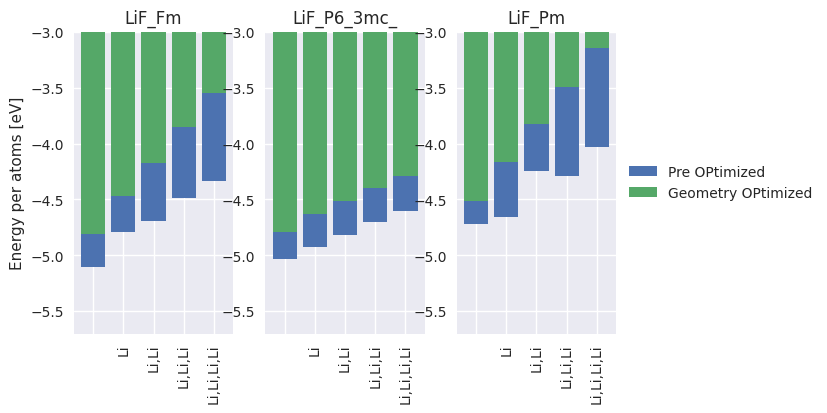

In [24]:
fig = plt.figure(figsize=[7, 4], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = {}
    system_id = results_df["system_id"].unique()
    spec = gridspec.GridSpec(ncols=len(system_id), nrows=1, figure=fig)
    for i, sim_id in enumerate(results_df["system_id"].unique()):
        ax[i] = fig.add_subplot(spec[i])
        idx = np.arange(len(results_df.index))
        sub_df = results_df.loc[results_df["system_id"] == sim_id]
        xticks = np.arange(len(sub_df))
        name = sub_df.index[0].split("-")[2]
        ax[i].bar(xticks, sub_df["scm_PO_energy_per_atom"], label="Pre OPtimized")
        ax[i].bar(xticks, sub_df["scm_energy_per_atom"], label="Geometry OPtimized")
        ax[i].set_ylim([-5.7, -3])
        ax[i].set_xticks(xticks)
        xticks_labels = [",".join(sites) for sites in sub_df["interstitial_element"]]
        ax[i].set_xticklabels(xticks_labels, rotation=90, ha="center")
        ax[i].set_title(name)
        # ax[i].set_xticks(idx)
        # ax[i].set_xticklabels(results_df.index, rotation=25, ha='right')
    #     ax[i].set_ylim([-5, -3.8])
    ax[len(results_df["system_id"].unique()) - 1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    ax[0].set_ylabel("Energy per atoms [eV]")
plt.show()
fig.savefig(os.path.join("plots", f"5-{CHEM_FORMULA}_interstitial_GO.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [78]:
scm.finish()

### Slab `PRE Optimization`

In [15]:
SIMsNAME = "6-Slabs_PO"

#### Setting `BAND` *Geopmetry Optimization*

In [16]:
settings = scm.Settings()
settings.input.ams.task = "GeometryOptimization"
settings.input.ams.GeometryOptimization.OptimizeLattice = "no"
settings.input.ams.GeometryOptimization.Convergence.Energy = scm.Units.convert(
    0.1, "kJ/mol", "Hartree"
)  # [Ha] The criterion for changes in the energy.
# The energy is considered converged when the change in energy is smaller than this threshold.
settings.input.ams.GeometryOptimization.Convergence.Gradients = scm.Units.convert(
    100, "kJ/mol/Ang", "Hartree/Ang"
)  # [Ha/Ang] Threshold for nuclear gradients.
settings.input.ams.GeometryOptimization.Convergence.StressEnergyPerAtom = scm.Units.convert(
    100, "kJ/mol", "Hartree"
)  # [Ha] Threshold used when optimizing the
# lattice vectors. The stress is considered ‘converged’ when the maximum value of
# stress_tensor * cell_volume / number_of_atoms is smaller than this threshold
settings.input.ams.GeometryOptimization.Convergence.Step = (
    0.05  # [Ang] The maximum Cartesian step allowed for a converged geometry.
)
settings.input.ams.GeometryOptimization.PretendConverged = "yes"
settings.input.ams.GeometryOptimization.MaxIterations = 50
# settings.input.ams.GeometryOptimization.Method = 'Quasi-Newton' # The SCMGO optimizer is a new implementation of a Quasi-Newton style optimizer
# working in delocalized coordinates
settings.input.BAND.basis.type = "SZ"  # DZ Double zeta basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
settings.input.BAND.basis.Core = "Medium"
settings.input.BAND.Dependency.Core = (
    0.8  # BAND calculates the overlap matrix of the core functions, and this should approximate the unit matrix.
)
# When the deviation is larger then the frozen-core overlap criterion the program stops.
# The default criterion (0.98) is fairly strict. The safest solution is to choose a smaller frozen core.
# For performance reasons, however, this may not be the preferred option.
# In practice you might still get reliable results by setting the criterion to 0.8
settings.input.BAND.xc.GGA = "PBE"  # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
#                                           # (https://doi.org/10.1103/PhysRevLett.100.136406)
# settings.input.BAND.xc.MetaGGA = 'postscf TPSS'   # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
#                                                     # TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)
# settings.input.BAND.xc.LDA = 'VWN'          # Parametrization of electron gas data given by Vosko, Wilk and Nusair (ref [1], formula version V).
# Among the available LDA options this is the more advanced one, including correlation effects to a fair extent.
# (https://doi.org/10.1139/p80-159)
settings.input.BAND.SCF.mixing = 0.1
settings.input.BAND.SCF.Iterations = 180
settings.input.BAND.SCF.Method = "MultiSecant"
settings.input.BAND.numericalquality = "Good"
settings.input.BAND.beckegrid.quality = "Normal"
settings.input.BAND.Convergence.Degenerate = (
    "Default"  # Smooths (slightly) occupation numbers around the Fermi level, so as to insure that nearly-degenerate
)
# states get (nearly-) identical occupations.
settings.input.BAND.RadialDefaults.NR = (
    10000  # Options for the logarithmic radial grid of the basis functions used in the subprogram Dirac
)

settings.input.BAND.CPVector = 128 * 4  # The code is vectorized and this key can be used to set the vector length
settings.input.BAND.KGRPX = 6  # Absolute upper bound on the number of k-points processed together.

#### Set-up `RUNNER`

In [17]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "PO"
CORES_PER_NODE = 128
CPUS_PER_CORE = 2
MAX_JOBS = 12

In [31]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[02.12|00:10:18] PLAMS working folder: /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/6-Slabs_PO


In [18]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [13]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '6-slabs')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    # apply 2D simmetry
    # system_ase.set_pbc([True, True, False])
    systems.append((system_name, fromASEtem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [33]:
# systems[10][1].lattice

Define jobs

In [34]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [35]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [36]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[02.12|00:10:26] JOB jobs STARTED
[02.12|00:10:26] JOB jobs/PO-6.0-0-LiF_Fm-3m_-3.18_001x2 STARTED
[02.12|00:10:26] JOB jobs/PO-6.0-1-LiF_P6_3mc_-3.17_001x2 STARTED
[02.12|00:10:26] JOB jobs/PO-6.0-2-LiF_Pm-3m_-2.89_001x2 STARTED
[02.12|00:10:26] JOB jobs/PO-6.1-0-LiF_Fm-3m_-3.18_001x3 STARTED
[02.12|00:10:26] JOB jobs/PO-6.1-1-LiF_P6_3mc_-3.17_001x3 STARTED
[02.12|00:10:26] JOB jobs/PO-6.1-2-LiF_Pm-3m_-2.89_001x3 STARTED
[02.12|00:10:26] JOB jobs/PO-6.10-0-LiF_Fm-3m_-3.18_012x3 STARTED
[02.12|00:10:26] JOB jobs/PO-6.10-1-LiF_P6_3mc_-3.17_012x3 STARTED
[02.12|00:10:26] JOB jobs/PO-6.10-2-LiF_Pm-3m_-2.89_012x3 STARTED
[02.12|00:10:26] JOB jobs/PO-6.11-0-LiF_Fm-3m_-3.18_012x4 STARTED
[02.12|00:10:26] JOB jobs/PO-6.11-1-LiF_P6_3mc_-3.17_012x4 STARTED
[02.12|00:10:26] JOB jobs/PO-6.11-2-LiF_Pm-3m_-2.89_012x4 STARTED
[02.12|00:10:26] JOB jobs/PO-6.2-0-LiF_Fm-3m_-3.18_001x4 STARTED
[02.12|00:10:26] JOB jobs/PO-6.2-1-LiF_P6_3mc_-3.17_001x4 STARTED
[02.12|00:10:26] JOB jobs/PO-6.2-2-LiF_Pm-3m_

In [ ]:
for i in range(len(systems)):
    name = systems[i][0]
    file = f"trainset_sim/{SIMsNAME}/jobs/PO-{name}/ams.log"
    if not os.path.exists(file):
        continue
    grandient = []
    energy = []
    grandient_t = []
    energy_t = []
    with open(file) as f:
        for line in f:
            # print(line)
            if "constrained gradient max" in line:
                # print(line)
                grandient.append(abs(float(line.split()[-3])))
                grandient_t.append(abs(float(line.split()[-2])))
            if "energy change" in line:
                # print(line)
                energy.append(abs(float(line.split()[-3])))
                energy_t.append(abs(float(line.split()[-2])))

    start_i = 0
    plt.title(f"PO-{name}")
    plt.semilogy(energy[start_i:], "s-")
    plt.semilogy(energy_t[start_i:], "s-r")
    plt.semilogy(grandient[start_i:], "o--")
    plt.semilogy(grandient_t[start_i:], "o--r")
    plt.show()

#### Post-processing

Move to end folder

In [19]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-0-LiF_Fm-3m_-3.18_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-1-LiF_P6_3mc_-3.17_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.2-1-LiF_P6_3mc_-3.17_001x4 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.8-0-LiF_Fm-3m_-3.18_111x4 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-2-LiF_Pm-3m_-2.89_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.0-1-LiF_P6_3mc_-3.17_001x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.8-1-LiF_P6_3mc_-3.17_111x4 FAILED


Save last configuration

In [20]:
dir_jobs = os.path.join(RUN_DIR, "jobs")
conf_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "6.1-slabs_PO")
make_dir(conf_dir)

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    name = sim_name[3:]
    mol = job.results.get_input_molecule()
    # print(os.path.join(conf_dir, f'{name}.cif'))
    mol = SCMtoASE(mol)
    mol.write(os.path.join(conf_dir, f"{name}.cif"), format="cif")

Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-0-LiF_Fm-3m_-3.18_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-1-LiF_P6_3mc_-3.17_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.2-1-LiF_P6_3mc_-3.17_001x4 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.8-0-LiF_Fm-3m_-3.18_111x4 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-2-LiF_Pm-3m_-2.89_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.0-1-LiF_P6_3mc_-3.17_001x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.8-1-LiF_P6_3mc_-3.17_111x4 FAILED


In [21]:
mol

Atoms(symbols='Li16F16', pbc=True, cell=[[5.119066, 0.0, 0.0], [-0.0, 10.2381320021, 5.1190660017], [0.0, 0.0, 7.678599]])

Post Processing

Load Material Project data

In [14]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

conf_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "6.1-slabs_PO")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "6-slabs")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [15]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    results_df.loc[sim_name[3:] + ".cif", "millers_str"] = str(results_df.loc[sim_name[3:] + ".cif", "millers"])
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_PO_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_PO_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])

results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))
results_df.to_json(os.path.join(conf_dir, "info.json"))

Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-0-LiF_Fm-3m_-3.18_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-1-LiF_P6_3mc_-3.17_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.2-1-LiF_P6_3mc_-3.17_001x4 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.8-0-LiF_Fm-3m_-3.18_111x4 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.9-2-LiF_Pm-3m_-2.89_012x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.0-1-LiF_P6_3mc_-3.17_001x2 FAILED
Simulation trainset_sim/6-Slabs_PO/jobs/PO-6.8-1-LiF_P6_3mc_-3.17_111x4 FAILED


In [16]:
results_df.head()

,millers,slabs,millers_str,scm_PO_energy,scm_PO_energy_per_atom,system_id
6.0-0-LiF_Fm-3m_-3.18_001x2.cif,"[0, 0, 1]",2,"[0, 0, 1]",-52.869952,-3.304372,0.0
6.1-0-LiF_Fm-3m_-3.18_001x3.cif,"[0, 0, 1]",3,"[0, 0, 1]",-79.203034,-3.300126,0.0
6.2-0-LiF_Fm-3m_-3.18_001x4.cif,"[0, 0, 1]",4,"[0, 0, 1]",-108.190278,-3.380946,0.0
6.3-0-LiF_Fm-3m_-3.18_011x2.cif,"[0, 1, 1]",2,"[0, 1, 1]",-57.632127,-3.602008,0.0
6.4-0-LiF_Fm-3m_-3.18_011x3.cif,"[0, 1, 1]",3,"[0, 1, 1]",-87.752700,-3.656362,0.0


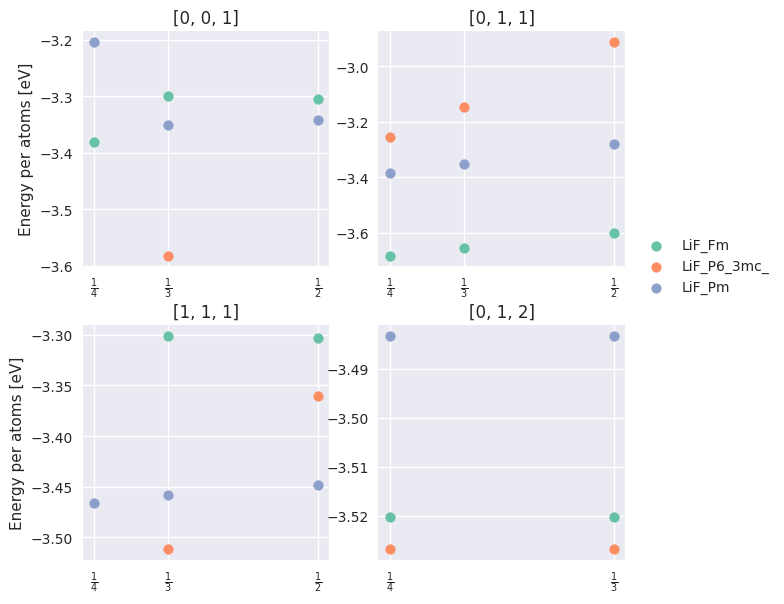

In [17]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = {}
    slabs_millers = results_df["millers_str"].unique()
    Set2 = mp.cm.get_cmap("Set2", 8)
    spec = gridspec.GridSpec(
        ncols=min([len(slabs_millers), 2]),
        nrows=len(slabs_millers) // 2 + len(slabs_millers) % 2,
        hspace=0.25,
        figure=fig,
    )
    for i, millers in enumerate(slabs_millers):
        ax[i] = fig.add_subplot(spec[i])
        sub_df = results_df.loc[results_df["millers_str"] == millers]
        systems_id = results_df["system_id"].unique()
        xticks = 1 / sub_df["slabs"].unique()
        xticks_labels = [f"$\\frac{{1}}{{{ns}}}$" for ns in sub_df["slabs"].unique()]
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels(xticks_labels, rotation=0, ha="center")
        ax[i].set_title(millers)
        for sys_id in systems_id:
            sub_df
            idx = np.arange(len(results_df.index))
            sub_sub_df = sub_df.loc[sub_df["system_id"] == sys_id]
            if not len(sub_sub_df.index) > 0:
                # print(sub_sub_df.head())
                continue
            name = sub_sub_df.index[0].split("-")[2]
            # print(1/sub_sub_df['slabs'], sub_sub_df['scm_PO_energy_per_atom'])
            ax[i].scatter(
                1 / sub_sub_df["slabs"],
                sub_sub_df["scm_PO_energy_per_atom"],
                color=Set2.colors[int(sys_id)],
                label=name,
            )

            # ax[i].set_xticks(idx)
            # ax[i].set_xticklabels(results_df.index, rotation=25, ha='right')
        # ax[i].set_ylim([-5.2, -3.8])
    #     ax[i].set_ylim([-5, -3.8])
    ax[3 - 2].legend(loc="center left", bbox_to_anchor=(1.02, 0.0))
    for i in range(0, len(ax), 2):
        ax[i].set_ylabel("Energy per atoms [eV]")
plt.show()
fig.savefig(os.path.join("plots", f"6-{CHEM_FORMULA}_slabs_PO.pdf"), dpi=300, bbox_inches="tight")

#### Finishing 

In [18]:
scm.finish()

### Slabs `Geopmetry Optimization`

In [25]:
SIMsNAME = "6-Slabs_GO"

#### Setting `BAND` *Geopmetry Optimization*

In [26]:
settings = scm.Settings()
settings.input.AMS.task = "GeometryOptimization"
settings.input.AMS.Properties.Gradients = "yes"
settings.input.AMS.Properties.StressTensor = "no"
settings.input.AMS.Properties.Hessian = "no"
settings.input.AMS.Properties.PESPointCharacter = "no"
settings.input.AMS.Properties.ElasticTensor = "no"
settings.input.AMS.GeometryOptimization.OptimizeLattice = "no"
settings.input.AMS.GeometryOptimization.Convergence.Energy = scm.Units.convert(
    0.1, "kJ/mol", "Hartree"
)  # [Ha] The criterion for changes in the energy.
# The energy is considered converged when the change in energy is smaller than this threshold.
settings.input.AMS.GeometryOptimization.Convergence.Gradients = scm.Units.convert(
    1000, "kJ/mol/Ang", "Hartree/Ang"
)  # [Ha/Ang] Threshold for nuclear gradients.
settings.input.AMS.GeometryOptimization.Convergence.StressEnergyPerAtom = scm.Units.convert(
    50, "kJ/mol", "Hartree"
)  # [Ha] Threshold used when optimizing the
# lattice vectors. The stress is considered ‘converged’ when the maximum value of
# stress_tensor * cell_volume / number_of_atoms is smaller than this threshold
settings.input.AMS.GeometryOptimization.Convergence.Step = (
    0.05  # [Ang] The maximum Cartesian step allowed for a converged geometry.
)
settings.input.AMS.GeometryOptimization.PretendConverged = "yes"
settings.input.AMS.GeometryOptimization.MaxIterations = 15
settings.input.BAND.basis.type = "DZP"  # DZP Double zeta polarized basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
# plus it can descrive the atom polarization since it add a p-function ()
settings.input.BAND.basis.Core = "Medium"
settings.input.BAND.Dependency.Core = (
    0.8  # BAND calculates the overlap matrix of the core functions, and this should approximate the unit matrix.
)
# When the deviation is larger then the frozen-core overlap criterion the program stops.
# The default criterion (0.98) is fairly strict. The safest solution is to choose a smaller frozen core.
# For performance reasons, however, this may not be the preferred option.
# In practice you might still get reliable results by setting the criterion to 0.8
# settings.input.BAND.xc.GGA = 'PBE'        # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
# (https://doi.org/10.1103/PhysRevLett.100.136406)
settings.input.BAND.xc.MetaGGA = (
    "TPSS"  # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
)
# TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)
settings.input.BAND.SCF.mixing = 0.05
settings.input.BAND.SCF.Iterations = 150
settings.input.BAND.SCF.Method = "MultiSecant"
settings.input.BAND.numericalquality = "Good"
settings.input.BAND.beckegrid.quality = "Good"
settings.input.BAND.Convergence.Degenerate = (
    "Default"  # Smooths (slightly) occupation numbers around the Fermi level, so as to insure that nearly-degenerate
)
# states get (nearly-) identical occupations.
settings.input.BAND.RadialDefaults.NR = (
    10000  # Options for the logarithmic radial grid of the basis functions used in the subprogram Dirac
)

settings.input.BAND.CPVector = 128 * 4  # The code is vectorized and this key can be used to set the vector length
settings.input.BAND.KGRPX = 6  # Absolute upper bound on the number of k-points processed together.

#### Set-up `RUNNER`

In [27]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "GO"
NODES = 4
CORES_PER_NODE = 64
CPUS_PER_CORE = 4
MAX_JOBS = 30

In [28]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[10:47:16] PLAMS working folder: /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/6-Slabs_GO


In [29]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [30]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '6.1-slabs_PO')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    # apply 2D simmetry
    system_ase.set_pbc([True, True, False])
    systems.append((system_name, fromASEystem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [31]:
# systems

Define jobs

In [32]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [33]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [34]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[10:47:38] JOB jobs STARTED
[10:47:39] JOB jobs/GO-6.0-0-LiF_Fm-3m_-3.18_001x2 STARTED
[10:47:39] JOB jobs/GO-6.0-2-LiF_Pm-3m_-2.89_001x2 STARTED
[10:47:39] JOB jobs/GO-6.1-0-LiF_Fm-3m_-3.18_001x3 STARTED
[10:47:39] JOB jobs/GO-6.1-1-LiF_P6_3mc_-3.17_001x3 STARTED
[10:47:39] JOB jobs/GO-6.1-2-LiF_Pm-3m_-2.89_001x3 STARTED
[10:47:39] JOB jobs/GO-6.10-0-LiF_Fm-3m_-3.18_012x3 STARTED
[10:47:39] JOB jobs/GO-6.10-1-LiF_P6_3mc_-3.17_012x3 STARTED
[10:47:39] JOB jobs/GO-6.10-2-LiF_Pm-3m_-2.89_012x3 STARTED
[10:47:39] JOB jobs/GO-6.11-0-LiF_Fm-3m_-3.18_012x4 STARTED
[10:47:39] JOB jobs/GO-6.11-1-LiF_P6_3mc_-3.17_012x4 STARTED
[10:47:39] JOB jobs/GO-6.11-2-LiF_Pm-3m_-2.89_012x4 STARTED
[10:47:39] JOB jobs/GO-6.2-0-LiF_Fm-3m_-3.18_001x4 STARTED
[10:47:39] JOB jobs/GO-6.2-2-LiF_Pm-3m_-2.89_001x4 STARTED
[10:47:39] JOB jobs/GO-6.3-0-LiF_Fm-3m_-3.18_011x2 STARTED
[10:47:39] JOB jobs/GO-6.3-1-LiF_P6_3mc_-3.17_011x2 STARTED
[10:47:39] JOB jobs/GO-6.3-2-LiF_Pm-3m_-2.89_011x2 STARTED
[10:47:39] JOB job

#### Post-processing

Move to end folder

In [16]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

[26.11|10:06:41] WARNING: Main KF file ams.rkf not present in /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/6-Slabs_GO/jobs/GO-6.8-2-LiF_Pm-3m_-2.89_012x4
[26.11|10:06:41] WARNING: Main KF file ams.rkf not present in /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/6-Slabs_GO/jobs/GO-6.14-0-LiF_Fm-3m_-3.18_012x4
[26.11|10:06:43] WARNING: Main KF file ams.rkf not present in /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/6-Slabs_GO/jobs/GO-6.9-2-LiF_Pm-3m_-2.89_012x2
[26.11|10:06:43] WARNING: Main KF file ams.rkf not present in /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/6-Slabs_GO/jobs/GO-6.13-1-LiF_P6_3mc_-3.17_012x3
[26.11|10:06:44] WARNING: Main KF file ams.rkf not present in /lus/cls01095/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/6-Slabs_GO/jobs/GO-6.8-0-LiF_Fm-3m_-3.18_012x4
[26.11|10:06:45] WARNING: Main KF file ams.rkf not present in 

Post Processing

Load Material Project data

In [9]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "6.1-slabs_PO")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [10]:
results_df

,millers,slabs,millers_str,scm_PO_energy,scm_PO_energy_per_atom,system_id
6.0-0-LiF_Fm-3m_-3.18_001x2.cif,"[0, 0, 1]",2,"[0, 0, 1]",-52.808963,-3.300560,0.0
6.1-0-LiF_Fm-3m_-3.18_001x3.cif,"[0, 0, 1]",3,"[0, 0, 1]",NaN,NaN,NaN
6.2-0-LiF_Fm-3m_-3.18_001x4.cif,"[0, 0, 1]",4,"[0, 0, 1]",-106.758556,-3.336205,0.0
6.3-0-LiF_Fm-3m_-3.18_011x2.cif,"[0, 1, 1]",2,"[0, 1, 1]",-57.597589,-3.599849,0.0
6.4-0-LiF_Fm-3m_-3.18_011x3.cif,"[0, 1, 1]",3,"[0, 1, 1]",-87.697327,-3.654055,0.0
6.5-0-LiF_Fm-3m_-3.18_011x4.cif,"[0, 1, 1]",4,"[0, 1, 1]",-117.823212,-3.681975,0.0
6.6-0-LiF_Fm-3m_-3.18_111x2.cif,"[1, 1, 1]",2,"[1, 1, 1]",NaN,NaN,NaN
6.7-0-LiF_Fm-3m_-3.18_111x3.cif,"[1, 1, 1]",3,"[1, 1, 1]",NaN,NaN,NaN
6.8-0-LiF_Fm-3m_-3.18_111x4.cif,"[1, 1, 1]",4,"[1, 1, 1]",NaN,NaN,NaN
6.9-0-LiF_Fm-3m_-3.18_012x2.cif,"[0, 1, 2]",2,"[0, 1, 2]",-52.769652,-3.298103,0.0


In [12]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])

results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.5-1-LiF_P6_3mc_-3.17_011x4 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.8-1-LiF_P6_3mc_-3.17_111x4 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.2-0-LiF_Fm-3m_-3.18_001x4 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.7-1-LiF_P6_3mc_-3.17_111x3 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.5-0-LiF_Fm-3m_-3.18_011x4 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.6-1-LiF_P6_3mc_-3.17_111x2 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.4-0-LiF_Fm-3m_-3.18_011x3 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.10-2-LiF_Pm-3m_-2.89_012x3 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.11-2-LiF_Pm-3m_-2.89_012x4 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.4-1-LiF_P6_3mc_-3.17_011x3 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.1-2-LiF_Pm-3m_-2.89_001x3 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.11-0-LiF_Fm-3m_-3.18_012x4 FAILED
Simulation trainset_sim/6-Slabs_GO/jobs/GO-6.9-1-LiF_P6_

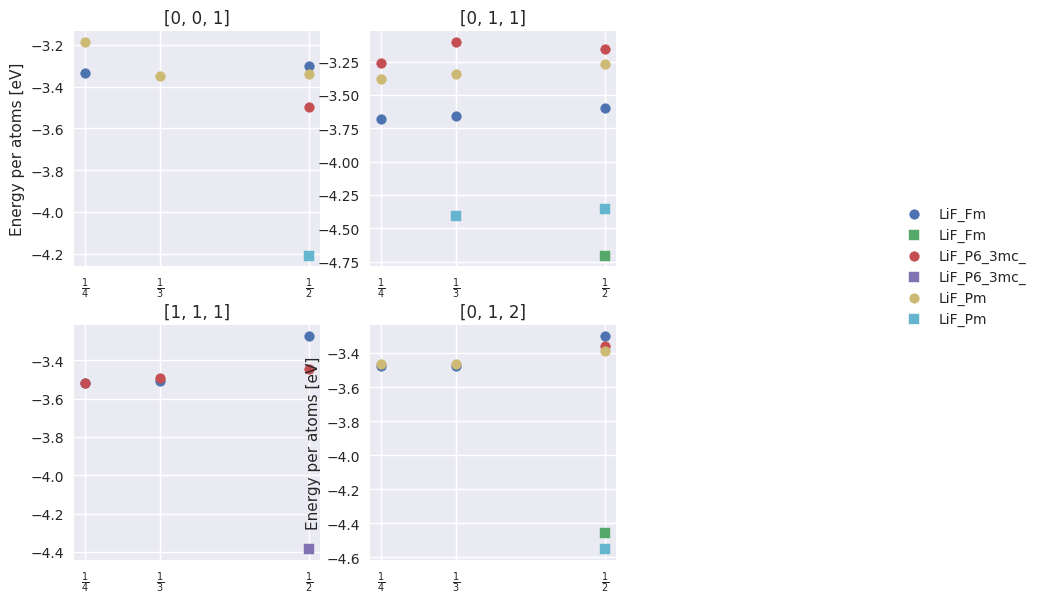

In [14]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax = {}
    slabs_millers = results_df["millers_str"].unique()
    spec = gridspec.GridSpec(
        ncols=min([len(slabs_millers), 2]),
        nrows=len(slabs_millers) // 2 + len(slabs_millers) % 2,
        hspace=0.25,
        figure=fig,
    )
    for i, millers in enumerate(slabs_millers):
        ax[i] = fig.add_subplot(spec[i])
        sub_df = results_df.loc[results_df["millers_str"] == millers]
        systems_id = results_df["system_id"].unique()
        xticks = 1 / sub_df["slabs"].unique()
        xticks_labels = [f"$\\frac{{1}}{{{ns}}}$" for ns in sub_df["slabs"].unique()]
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels(xticks_labels, rotation=0, ha="center")
        ax[i].set_title(millers)
        for sys_id in systems_id:
            sub_df
            idx = np.arange(len(results_df.index))
            sub_sub_df = sub_df.loc[sub_df["system_id"] == sys_id]
            if not len(sub_sub_df.index) > 0:
                # print(sub_sub_df.head())
                continue
            name = sub_sub_df.index[0].split("-")[2]
            # print(1/sub_sub_df['slabs'], sub_sub_df['scm_PO_energy_per_atom'])
            ax[i].scatter(1 / sub_sub_df["slabs"], sub_sub_df["scm_PO_energy_per_atom"], label=name)
            ax[i].scatter(1 / sub_sub_df["slabs"], sub_sub_df["scm_energy_per_atom"], label=name, marker="s")
            # ax[i].set_xticks(idx)
            # ax[i].set_xticklabels(results_df.index, rotation=25, ha='right')
        # ax[i].set_ylim([-5.2, -3.8])
    #     ax[i].set_ylim([-5, -3.8])
    ax[3 - 2].legend(loc="center left", bbox_to_anchor=(2.1, 0.0))
    for i in range(0, len(ax), 3):
        ax[i].set_ylabel("Energy per atoms [eV]")
plt.show()
# fig.savefig(os.path.join("plots", f"5-{CHEM_FORMULA}_interstitial_PO.pdf"), dpi=300, bbox_inches='tight')

#### Finishing 

In [13]:
scm.finish()

### Bulk 500K `ab initio MD`

In [4]:
SIMsNAME = "10-Bulk_300K_MD"

#### Setting `DFTB` *ab initio MD*

In [56]:
STEPS = 1000
TIMESTEP = 0.25  # [fs]
TEMP = 500
settings = scm.Settings()
settings.input.ams.task = "MolecularDynamics"
settings.input.ams.MolecularDynamics.NSteps = STEPS
settings.input.ams.MolecularDynamics.TimeStep = TIMESTEP
settings.input.ams.MolecularDynamics.Trajectory.PrintFreq = 5
settings.input.ams.MolecularDynamics.Trajectory.SamplingFreq = 50
# settings.input.ams.MolecularDynamics.Preserve.CenterOfMass = 'yes'
settings.input.ams.MolecularDynamics.InitialVelocities.Temperature = TEMP
settings.input.ams.MolecularDynamics.Thermostat.Type = "Berendsen"
settings.input.ams.MolecularDynamics.Thermostat.Temperature = TEMP
settings.input.ams.MolecularDynamics.Thermostat.Tau = int(100 * TIMESTEP)
# Engine
settings.input.DFTB.Model = "NonSCC-GFN1-xTB"
# settings.input.DFTB.SCC.Iterations = 500
# settings.input.DFTB.DispersionCorrection = 'Auto'

#### Set-up `RUNNER`

In [57]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "MD"
NODES = 1
CORES_PER_NODE = 128
CPUS_PER_CORE = 2
MAX_JOBS = 0

In [7]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[12:36:29] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/11-Bulk_500K_MD


In [8]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [9]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '11-bulk_500K')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASEystem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [10]:
systems

[('11.0-0-LiF_Fm-3m_-3.18_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fac99a34518>),
 ('11.0-1-LiF_P6_3mc_-3.17_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fac99a38a20>),
 ('11.0-2-LiF_Pm-3m_-2.89_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fa9d2f15b70>)]

Define jobs

In [11]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [12]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [ ]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[12:36:49] JOB jobs STARTED
[12:36:49] JOB jobs/MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 STARTED
[12:36:49] JOB jobs/MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 STARTED
[12:36:49] JOB jobs/MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 STARTED


#### Post-processing

Move to end folder

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [58]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [59]:
results_df

,unitcell_repetition
11.0-0-LiF_Fm-3m_-3.18_2x2x3.cif,12
11.0-1-LiF_P6_3mc_-3.17_2x2x3.cif,12
11.0-2-LiF_Pm-3m_-2.89_2x2x3.cif,12


In [60]:
temp_df = pd.DataFrame(index=results_df.index, columns=["scm_step", "scm_Temp", "scm_energy_per_atom_t"])

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    Nentry = job_result.read_rkf_section("History")["nEntries"]
    energy = scm.Units.convert(
        job_result.read_rkf_section("History")[f"Energy({Nentry})"], "au", "eV"
    )  # scm.Units.convert(job_result.get_energy(), 'au', 'eV')
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    temp_df.at[sim_name[3:] + ".cif", "scm_step"] = np.array(job_result.get_history_property("Step"))
    temp_df.at[sim_name[3:] + ".cif", "scm_Temp"] = np.array(job_result.read_rkf_section("MDHistory")["Temperature(1)"])
    temp_df.at[sim_name[3:] + ".cif", "scm_energy_per_atom_t"] = (
        np.array(job_result.get_history_property("Energy")) / Na
    )

results_df = pd.concat([results_df, temp_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

[22:58:56] Job MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 reported warnings. Please check the the output
[22:58:56] Job MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 reported warnings. Please check the the output
[22:58:56] Job MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 reported warnings. Please check the the output


In [61]:
results_df

,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id,scm_step,scm_Temp,scm_energy_per_atom_t
11.0-0-LiF_Fm-3m_-3.18_2x2x3.cif,12,-1855.574178,-77.315591,0.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[499.9999999999999, 416.923323063444, 271.1582...","[-2.8434003513590658, -2.842952894535068, -2.8..."
11.0-1-LiF_P6_3mc_-3.17_2x2x3.cif,12,-3705.435048,-77.196564,1.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[499.9999999999999, 389.0072525130963, 325.165...","[-2.8394662073566574, -2.8388537012790294, -2...."
11.0-2-LiF_Pm-3m_-2.89_2x2x3.cif,12,-1854.542496,-77.272604,2.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[500.0, 424.927725103416, 320.27012569595587, ...","[-2.8405855542363496, -2.8401801382610117, -2...."


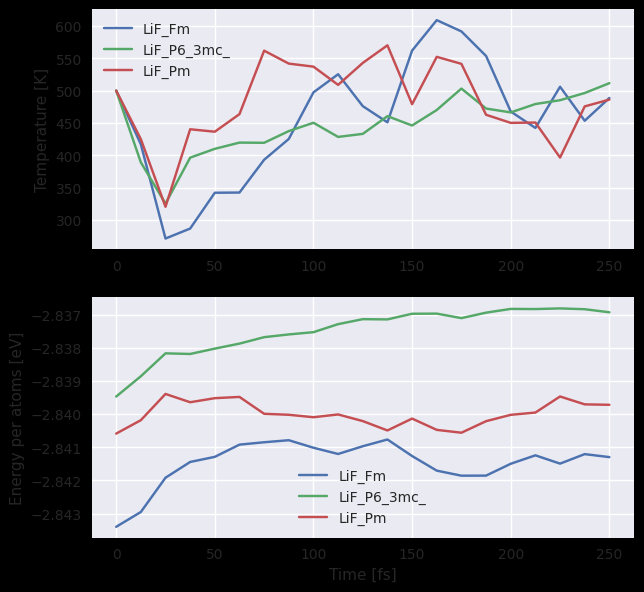

In [62]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    idx = np.arange(len(results_df.index))
    for sim in results_df.index:
        name = sim.split("-")[2]
        ax1.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_Temp"], label=name)
        ax2.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_energy_per_atom_t"], label=name)

    ax1.set_ylabel("Temperature [K]")
    ax2.set_ylabel("Energy per atoms [eV]")
    ax2.set_xlabel("Time [fs]")
    ax1.legend()
    ax2.legend()

plt.show()
fig.savefig(os.path.join("plots", f"11-{CHEM_FORMULA}_bulk_500K_MD.pdf"), dpi=300, bbox_inches="tight")

#### Save frames 

In [63]:
dir_jobs = os.path.join(RUN_DIR, "jobs")
conf_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11.1-bulk_500K_frames")
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

make_dir(conf_dir)
last_n_frames = 10
nskip = 2
frame_results_df = pd.DataFrame(columns=["step", "time", "unitcell_repetition"])

mols_ase = []

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    name = sim_name[3:]
    steps = job_result.get_history_property("Step")
    n_frame = len(steps)
    n_rep = results_df.loc[f"{name}.cif", "unitcell_repetition"]
    for i_frame in range(n_frame - last_n_frames * nskip + 1, n_frame, nskip):
        frame_name = f"{name}_{steps[i_frame] * TIMESTEP:1.1f}ps"
        mol = job.results.get_history_molecule(i_frame + 1)
        # print(os.path.join(conf_dir, f'{name}.cif'))
        mol = SCMtoASE(mol)
        mol.write(os.path.join(conf_dir, f"{frame_name}.cif"), format="cif")
        frame_results_df.loc[f"{frame_name}.cif", "unitcell_repetition"] = n_rep
        frame_results_df.loc[f"{frame_name}.cif", "step"] = steps[i_frame]
        frame_results_df.loc[f"{frame_name}.cif", "time"] = steps[i_frame] * TIMESTEP
        mols_ase.append(mol.copy())

frame_results_df.to_json(os.path.join(conf_dir, "info.json"))

[22:59:07] Job MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 reported warnings. Please check the the output
[22:59:07] Job MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 reported warnings. Please check the the output
[22:59:08] Job MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 reported warnings. Please check the the output


In [64]:
frame_results_df

,step,time,unitcell_repetition
11.0-0-LiF_Fm-3m_-3.18_2x2x3_25.0ps.cif,100,25,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_50.0ps.cif,200,50,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_75.0ps.cif,300,75,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_100.0ps.cif,400,100,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_125.0ps.cif,500,125,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_150.0ps.cif,600,150,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_175.0ps.cif,700,175,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_200.0ps.cif,800,200,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_225.0ps.cif,900,225,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_250.0ps.cif,1000,250,12


/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



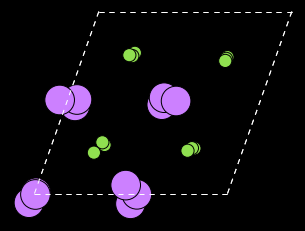

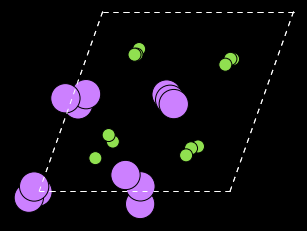

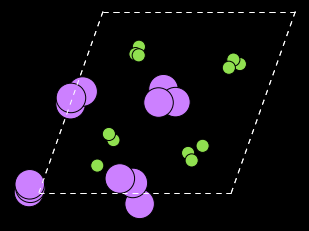

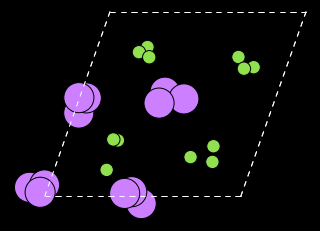

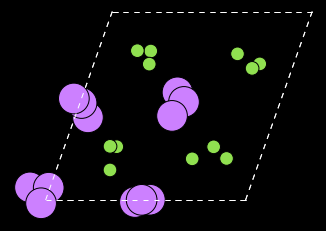

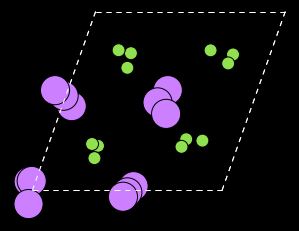

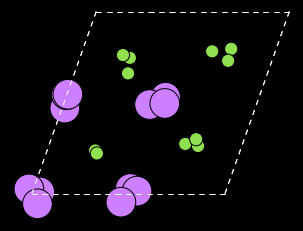

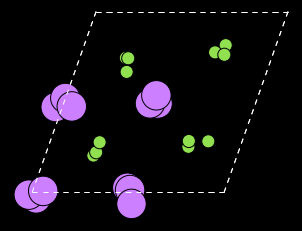

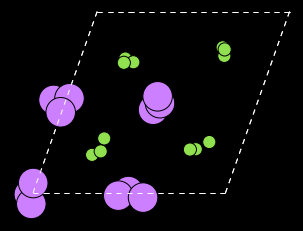

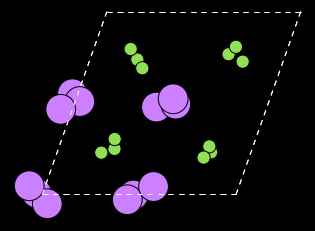

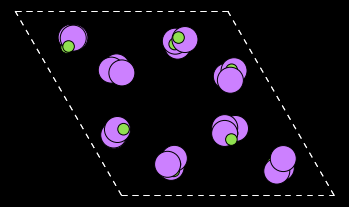

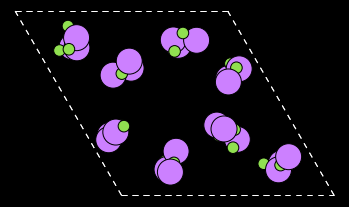

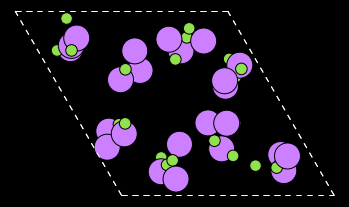

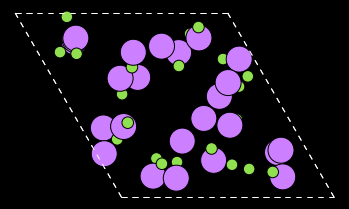

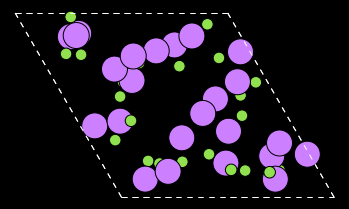

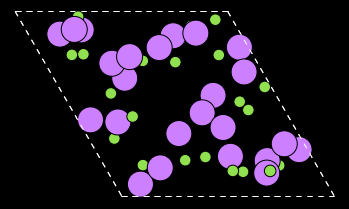

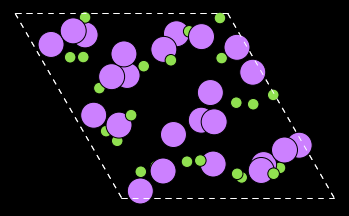

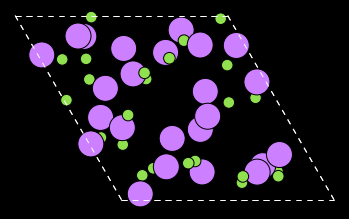

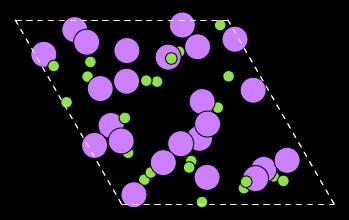

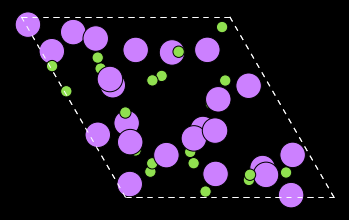

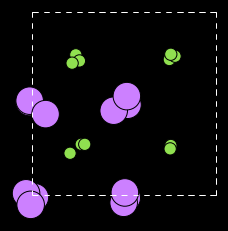

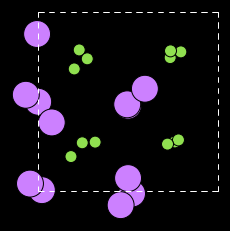

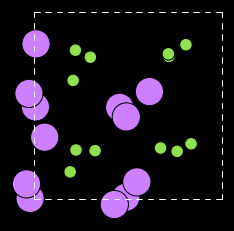

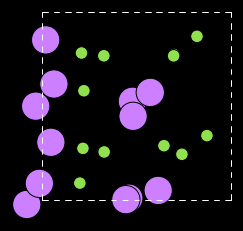

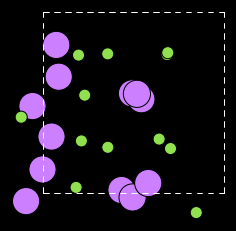

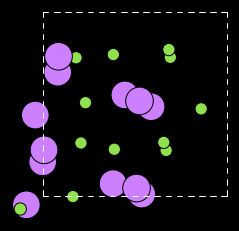

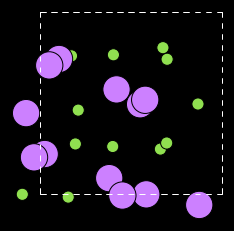

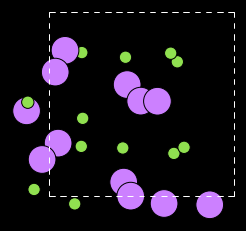

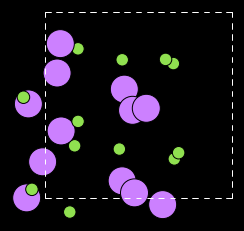

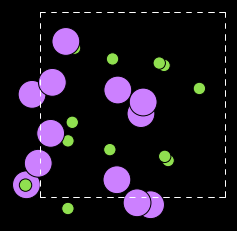

In [65]:
from ase.visualize.plot import plot_atoms

file_name = frame_results_df.index

for name, sys in zip(file_name, mols_ase):
    fig, ax = plt.subplots()
    plot_atoms(sys, ax, radii=0.3, rotation=("0x,0y,0z"))
    ax.set_axis_off()
    fig.savefig(os.path.join("plots", "sys-" + name[:-4] + ".pdf"), dpi=200)

In [ ]:
from ase.visualize import view

v = view(mols_ase, viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(Li2O_ase)
# v.view.add_unitcell(Li2O_ase)
# v.view.display(gui=False)
v

#### Finishing 

In [66]:
scm.finish()

### Bulk 500 K `Single Point`

In [67]:
SIMsNAME = "11.1-Bulk_500K_SP"

#### Setting `DFTB` *ab initio MD*

In [68]:
settings = scm.Settings()
settings.input.AMS.task = "SinglePoint"
settings.input.AMS.Properties.Gradients = "yes"
settings.input.AMS.Properties.StressTensor = "no"
settings.input.AMS.Properties.Hessian = "no"
settings.input.AMS.Properties.PESPointCharacter = "no"
settings.input.AMS.Properties.ElasticTensor = "no"
settings.input.AMS.GeometryOptimization.OptimizeLattice = "no"
# settings.input.ams.properties.normalmodes = 'Yes'
settings.input.BAND.basis.type = "DZP"  # DZP Double zeta polarized basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
# plus it can descrive the atom polarization since it add a p-function ()
settings.input.BAND.xc.GGA = "PBE"  # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
# (https://doi.org/10.1103/PhysRevLett.100.136406)
settings.input.BAND.xc.MetaGGA = "postscf TPSS"  # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
# TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)

#### Set-up `RUNNER`

In [69]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "SP"
NODES = 4
CORES_PER_NODE = 32
CPUS_PER_CORE = 4
MAX_JOBS = 64

In [70]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[23:00:10] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/11.1-Bulk_500K_SP


In [71]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [72]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '11.1-bulk_500K_frames')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASEystem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [73]:
# systems

Define jobs

In [74]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2021.104"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [75]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [76]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[23:00:37] JOB jobs STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_100.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_125.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_150.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_175.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_200.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_225.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_25.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_250.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_50.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_75.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_100.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_125.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_150.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_175.0ps STARTED
[23:00:37] JOB jobs

#### Post-processing

Move to end folder

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [ ]:
results_df

,unitcell_repetition
7.0-0-LiF_Fm-3m_-3.18_3x3x3.cif,27
7.0-1-LiF_P6_3mc_-3.17_3x3x3.cif,27
7.0-2-LiF_Pm-3m_-2.89_3x3x3.cif,27


In [ ]:
temp_df = pd.DataFrame(index=results_df.index, columns=["scm_step", "scm_Temp", "scm_energy_per_atom_t"])

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    Nentry = job_result.read_rkf_section("History")["nEntries"]
    energy = scm.Units.convert(
        job_result.read_rkf_section("History")[f"Energy({Nentry})"], "au", "eV"
    )  # scm.Units.convert(job_result.get_energy(), 'au', 'eV')
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    temp_df.at[sim_name[3:] + ".cif", "scm_step"] = np.array(job_result.get_history_property("Step"))
    temp_df.at[sim_name[3:] + ".cif", "scm_Temp"] = np.array(job_result.read_rkf_section("MDHistory")["Temperature(1)"])
    temp_df.at[sim_name[3:] + ".cif", "scm_energy_per_atom_t"] = (
        np.array(job_result.get_history_property("Energy")) / Na
    )

results_df = pd.concat([results_df, temp_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

In [ ]:
results_df

,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id,scm_step,scm_Temp,scm_energy_per_atom_t
7.0-0-LiF_Fm-3m_-3.18_3x3x3.cif,27,-4163.214306,-77.096561,0.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2600.0, 2227.472837617847, 1746.6540792818357...","[-2.844426643130874, -2.842366090997381, -2.83..."
7.0-1-LiF_P6_3mc_-3.17_3x3x3.cif,27,-8318.727662,-77.025256,1.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2600.0, 2201.8829583416705, 2011.420067554859...","[-2.8400756492875705, -2.837850360580547, -2.8..."
7.0-2-LiF_Pm-3m_-2.89_3x3x3.cif,27,-4162.027782,-77.074589,2.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2599.9999999999995, 2307.5056676702957, 1673....","[-2.8410294274160868, -2.8393977166355455, -2...."


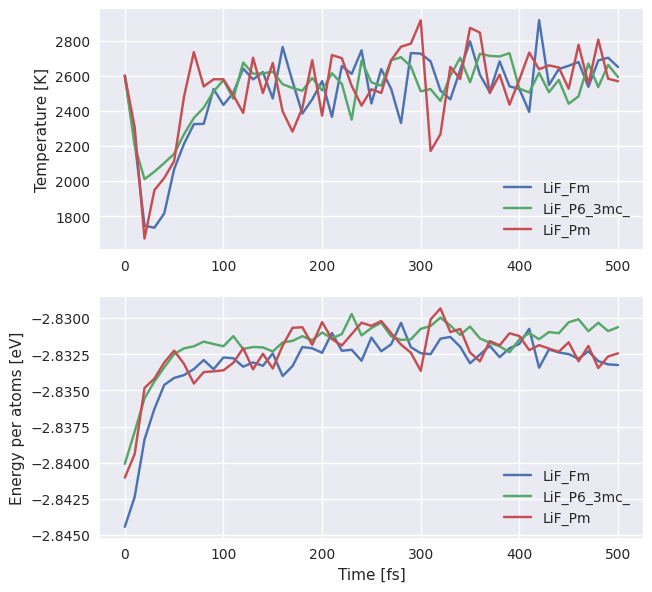

In [ ]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    idx = np.arange(len(results_df.index))
    for sim in results_df.index:
        name = sim.split("-")[2]
        ax1.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_Temp"], label=name)
        ax2.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_energy_per_atom_t"], label=name)

    ax1.set_ylabel("Temperature [K]")
    ax2.set_ylabel("Energy per atoms [eV]")
    ax2.set_xlabel("Time [fs]")
    ax1.legend()
    ax2.legend()

plt.show()
fig.savefig(os.path.join("plots", f"11.1-{CHEM_FORMULA}_bulk_500K.pdf"), dpi=300, bbox_inches="tight")

In [ ]:
scm.finish()

### Bond ` Potential Energy Surface` 

In [26]:
SIMsNAME = "9-Bond_PES_ADF"

#### Setting `ADF` *Single Point*

In [27]:
settings = scm.Settings()
settings.input.AMS.task = "PESScan"
settings.input.AMS.PESScan.ScanCoordinate.nPoints = 25
settings.input.AMS.PESScan.ScanCoordinate.Distance = "1 2 .75 3.5"  # atomIdx1 atomIdx2 startDist endDist

settings.input.ADF.basis.type = "TZ2P"  # DZP Double zeta polarized basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
# plus it can descrive the atom polarization since it add a p-function ()
settings.input.ADF.xc.GGA = "PBE"  # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
# (https://doi.org/10.1103/PhysRevLett.100.136406)
settings.input.ADF.xc.MetaGGA = "postscf TPSS"  # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
# TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)
settings.input.ADF.numericalquality = "Good"
settings.input.ADF.beckegrid.quality = "Good"
settings.input.ADF.SCF.Iterations = 2000
settings.input.ADF.SCF.DIIS.N = 25
settings.input.ADF.SCF.DIIS.Cyc = 30
settings.input.ADF.SCF.Mixing = 0.015
settings.input.ADF.SCF.Mixing1 = 0.09
settings.input.ADF.OCCUPATIONS = "ElectronicTemperature=300"

# sett.input.adf.scf.mixing = 0.3         # Push a bit convergence
# sett.input.adf.scf.mixing1 = 0.3
# sett.input.adf.numericalquality = 'Good'
# sett.input.adf.beckegrid.quality = 'Good'

#### Set-up `RUNNER`

In [28]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "PES"
NODES = 1
CORES_PER_NODE = 128
CPUS_PER_CORE = 2
MAX_JOBS = 60

In [29]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[20:45:09] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/9-Bond_PES_ADF


In [30]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [31]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '9-bond_pes')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    system_ase.set_pbc(False)
    systems.append((system_name, fromASEtem_ase)))

Define jobs

In [32]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job_dir = os.path.join(RUN_DIR, "jobs", sim_name)
    if os.path.exists(job_dir):
        job = scm.AMSJob.load_external(job_dir, settings=settings)
        if not job.check():
            print(f"sim {sim_name} FAILE will rerun it")
        else:
            continue
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [33]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [34]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[20:45:14] JOB jobs STARTED
[20:45:14] JOB jobs/PES-9.0-F-F-d_1.427 STARTED
[20:45:14] JOB jobs/PES-9.1-Li-F-d_2.042 STARTED
[20:45:14] JOB jobs/PES-9.2-Li-Li-d_3.041 STARTED
[20:47:10] Job jobs/PES-9.2-Li-Li-d_3.041 reported warnings. Please check the the output
[20:47:10] JOB jobs/PES-9.2-Li-Li-d_3.041 SUCCESSFUL
[20:47:24] Job jobs/PES-9.1-Li-F-d_2.042 reported warnings. Please check the the output
[20:47:24] JOB jobs/PES-9.1-Li-F-d_2.042 SUCCESSFUL
[20:47:30] Job jobs/PES-9.0-F-F-d_1.427 reported warnings. Please check the the output
[20:47:30] JOB jobs/PES-9.0-F-F-d_1.427 SUCCESSFUL
[20:47:34] JOB jobs SUCCESSFUL


#### Post-processing

Move to end folder

In [35]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [73]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "9-bond_pes")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [74]:
results_df.head()

,system,ai,aj,d
9.0-F-F-d_1.427.cif,0,F,F,1.426753
9.1-Li-F-d_2.042.cif,1,Li,F,2.041714
9.2-Li-Li-d_3.041.cif,2,Li,Li,3.041327


In [75]:
new_df = pd.DataFrame(columns=["pes_scan_energy", "pes_scan_x", "pes_scan_energy_per_atom"])

for job_dir in np.sort(glob.glob(os.path.join(dir_jobs, "*"))):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.readrkf("PESScan", "PES"), "au", "eV")
    energy = np.array(energy, dtype="float")
    energy_x = scm.Units.convert(job_result.readrkf("PESScan", "PESCoords"), "au", "A")
    energy_x = np.array(energy_x, dtype="float")
    new_df.loc[sim_name[4:] + ".cif", "pes_scan_energy"] = energy
    new_df.loc[sim_name[4:] + ".cif", "pes_scan_x"] = energy_x
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    new_df.loc[sim_name[4:] + ".cif", "pes_scan_energy_per_atom"] = energy_per_atom

results_df = pd.concat([results_df, new_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

[21:26:55] Job PES-9.0-F-F-d_1.427 reported warnings. Please check the the output
[21:26:55] Job PES-9.1-Li-F-d_2.042 reported warnings. Please check the the output
[21:26:55] Job PES-9.2-Li-Li-d_3.041 reported warnings. Please check the the output


In [67]:
results_df.head()

,system,ai,aj,d,pes_scan_energy,pes_scan_x,pes_scan_energy_per_atom
9.0-F-F-d_1.427.cif,0,F,F,1.426753,"[39.982970211947205, 16.902044263257736, 5.615...","[0.7499999999999999, 0.8645833333333333, 0.979...","[19.991485105973602, 8.451022131628868, 2.8076..."
9.1-Li-F-d_2.042.cif,1,Li,F,2.041714,"[23.62239159005305, 10.186836650242858, 2.1453...","[0.7499999999999999, 0.8645833333333333, 0.979...","[11.811195795026524, 5.093418325121429, 1.0726..."
9.2-Li-Li-d_3.041.cif,2,Li,Li,3.041327,"[6.583553048913819, 5.611823265837855, 4.69512...","[0.7499999999999999, 0.8645833333333333, 0.979...","[3.2917765244569095, 2.8059116329189275, 2.347..."


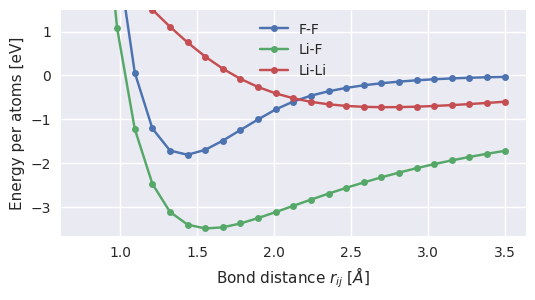

In [86]:
fig = plt.figure(figsize=[6, 3], dpi=100, facecolor="w")
results_df_2 = pd.read_json(os.path.join(ALLSIM_DIR, f"results_8-Bond_SP.json"))

with plt.style.context("./articles_seaborn.mplstyle"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax = fig.add_subplot(spec[0])
    for i in results_df["system"].unique():
        sub_df = results_df.loc[results_df["system"] == i]
        ax.plot(
            sub_df["pes_scan_x"].values[0],
            sub_df["pes_scan_energy_per_atom"].values[0],
            marker="o",
            markersize=5,
            label=f"{sub_df.iloc[0,1]}-{sub_df.iloc[0,2]}",
        )
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(np.concatenate(results_df["pes_scan_energy_per_atom"].values).min() * 1.05, 1.5)
    ax.set_xlabel(r"Bond distance $r_{ij}$ [$\AA$]")
    ax.set_ylabel("Energy per atoms [eV]")
fig.savefig(os.path.join("plots", f"9-{CHEM_FORMULA}_bond_PES.pdf"), dpi=300, bbox_inches="tight", facecolor="none")

#### Finishing 

In [19]:
scm.finish()

### Bond ` Potential Energy Surface` 

In [26]:
SIMsNAME = "9-Bond_PES_ADF"

#### Setting `ADF` *Single Point*

In [27]:
settings = scm.Settings()
settings.input.AMS.task = "PESScan"
settings.input.AMS.PESScan.ScanCoordinate.nPoints = 25
settings.input.AMS.PESScan.ScanCoordinate.Distance = "1 2 .75 3.5"  # atomIdx1 atomIdx2 startDist endDist

settings.input.ADF.basis.type = "TZ2P"  # DZP Double zeta polarized basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
# plus it can descrive the atom polarization since it add a p-function ()
settings.input.ADF.xc.GGA = "PBE"  # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
# (https://doi.org/10.1103/PhysRevLett.100.136406)
settings.input.ADF.xc.MetaGGA = "postscf TPSS"  # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
# TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)
settings.input.ADF.numericalquality = "Good"
settings.input.ADF.beckegrid.quality = "Good"
settings.input.ADF.SCF.Iterations = 2000
settings.input.ADF.SCF.DIIS.N = 25
settings.input.ADF.SCF.DIIS.Cyc = 30
settings.input.ADF.SCF.Mixing = 0.015
settings.input.ADF.SCF.Mixing1 = 0.09
settings.input.ADF.OCCUPATIONS = "ElectronicTemperature=300"

# sett.input.adf.scf.mixing = 0.3         # Push a bit convergence
# sett.input.adf.scf.mixing1 = 0.3
# sett.input.adf.numericalquality = 'Good'
# sett.input.adf.beckegrid.quality = 'Good'

#### Set-up `RUNNER`

In [28]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "PES"
NODES = 1
CORES_PER_NODE = 128
CPUS_PER_CORE = 2
MAX_JOBS = 60

In [29]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[20:45:09] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/9-Bond_PES_ADF


In [30]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [31]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '9-bond_pes')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    system_ase.set_pbc(False)
    systems.append((system_name, fromASEsystem_ase)))

Define jobs

In [32]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job_dir = os.path.join(RUN_DIR, "jobs", sim_name)
    if os.path.exists(job_dir):
        job = scm.AMSJob.load_external(job_dir, settings=settings)
        if not job.check():
            print(f"sim {sim_name} FAILE will rerun it")
        else:
            continue
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [33]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [34]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[20:45:14] JOB jobs STARTED
[20:45:14] JOB jobs/PES-9.0-F-F-d_1.427 STARTED
[20:45:14] JOB jobs/PES-9.1-Li-F-d_2.042 STARTED
[20:45:14] JOB jobs/PES-9.2-Li-Li-d_3.041 STARTED
[20:47:10] Job jobs/PES-9.2-Li-Li-d_3.041 reported warnings. Please check the the output
[20:47:10] JOB jobs/PES-9.2-Li-Li-d_3.041 SUCCESSFUL
[20:47:24] Job jobs/PES-9.1-Li-F-d_2.042 reported warnings. Please check the the output
[20:47:24] JOB jobs/PES-9.1-Li-F-d_2.042 SUCCESSFUL
[20:47:30] Job jobs/PES-9.0-F-F-d_1.427 reported warnings. Please check the the output
[20:47:30] JOB jobs/PES-9.0-F-F-d_1.427 SUCCESSFUL
[20:47:34] JOB jobs SUCCESSFUL


#### Post-processing

Move to end folder

In [35]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [73]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "9-bond_pes")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [74]:
results_df.head()

,system,ai,aj,d
9.0-F-F-d_1.427.cif,0,F,F,1.426753
9.1-Li-F-d_2.042.cif,1,Li,F,2.041714
9.2-Li-Li-d_3.041.cif,2,Li,Li,3.041327


In [75]:
new_df = pd.DataFrame(columns=["pes_scan_energy", "pes_scan_x", "pes_scan_energy_per_atom"])

for job_dir in np.sort(glob.glob(os.path.join(dir_jobs, "*"))):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.readrkf("PESScan", "PES"), "au", "eV")
    energy = np.array(energy, dtype="float")
    energy_x = scm.Units.convert(job_result.readrkf("PESScan", "PESCoords"), "au", "A")
    energy_x = np.array(energy_x, dtype="float")
    new_df.loc[sim_name[4:] + ".cif", "pes_scan_energy"] = energy
    new_df.loc[sim_name[4:] + ".cif", "pes_scan_x"] = energy_x
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    new_df.loc[sim_name[4:] + ".cif", "pes_scan_energy_per_atom"] = energy_per_atom

results_df = pd.concat([results_df, new_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

[21:26:55] Job PES-9.0-F-F-d_1.427 reported warnings. Please check the the output
[21:26:55] Job PES-9.1-Li-F-d_2.042 reported warnings. Please check the the output
[21:26:55] Job PES-9.2-Li-Li-d_3.041 reported warnings. Please check the the output


In [67]:
results_df.head()

,system,ai,aj,d,pes_scan_energy,pes_scan_x,pes_scan_energy_per_atom
9.0-F-F-d_1.427.cif,0,F,F,1.426753,"[39.982970211947205, 16.902044263257736, 5.615...","[0.7499999999999999, 0.8645833333333333, 0.979...","[19.991485105973602, 8.451022131628868, 2.8076..."
9.1-Li-F-d_2.042.cif,1,Li,F,2.041714,"[23.62239159005305, 10.186836650242858, 2.1453...","[0.7499999999999999, 0.8645833333333333, 0.979...","[11.811195795026524, 5.093418325121429, 1.0726..."
9.2-Li-Li-d_3.041.cif,2,Li,Li,3.041327,"[6.583553048913819, 5.611823265837855, 4.69512...","[0.7499999999999999, 0.8645833333333333, 0.979...","[3.2917765244569095, 2.8059116329189275, 2.347..."


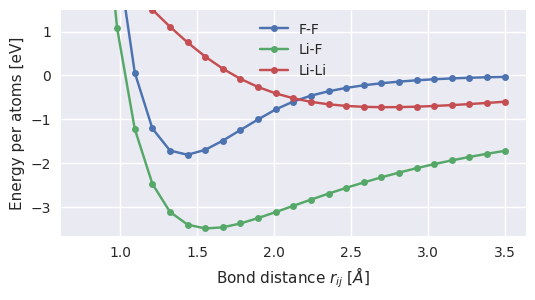

In [86]:
fig = plt.figure(figsize=[6, 3], dpi=100, facecolor="w")
results_df_2 = pd.read_json(os.path.join(ALLSIM_DIR, f"results_8-Bond_SP.json"))

with plt.style.context("./articles_seaborn.mplstyle"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax = fig.add_subplot(spec[0])
    for i in results_df["system"].unique():
        sub_df = results_df.loc[results_df["system"] == i]
        ax.plot(
            sub_df["pes_scan_x"].values[0],
            sub_df["pes_scan_energy_per_atom"].values[0],
            marker="o",
            markersize=5,
            label=f"{sub_df.iloc[0,1]}-{sub_df.iloc[0,2]}",
        )
    ax.legend()
    ylim = ax.get_ylim()
    ax.set_ylim(np.concatenate(results_df["pes_scan_energy_per_atom"].values).min() * 1.05, 1.5)
    ax.set_xlabel(r"Bond distance $r_{ij}$ [$\AA$]")
    ax.set_ylabel("Energy per atoms [eV]")
fig.savefig(os.path.join("plots", f"9-{CHEM_FORMULA}_bond_PES.pdf"), dpi=300, bbox_inches="tight", facecolor="none")

In [ ]:
np.concatenate

#### Finishing 

In [19]:
scm.finish()

### Bulk 500K `ab initio MD`

In [4]:
SIMsNAME = "10-Bulk_300K_MD"

#### Setting `DFTB` *ab initio MD*

In [56]:
STEPS = 1000
TIMESTEP = 0.25  # [fs]
TEMP = 500
settings = scm.Settings()
settings.input.ams.task = "MolecularDynamics"
settings.input.ams.MolecularDynamics.NSteps = STEPS
settings.input.ams.MolecularDynamics.TimeStep = TIMESTEP
settings.input.ams.MolecularDynamics.Trajectory.PrintFreq = 5
settings.input.ams.MolecularDynamics.Trajectory.SamplingFreq = 50
# settings.input.ams.MolecularDynamics.Preserve.CenterOfMass = 'yes'
settings.input.ams.MolecularDynamics.InitialVelocities.Temperature = TEMP
settings.input.ams.MolecularDynamics.Thermostat.Type = "Berendsen"
settings.input.ams.MolecularDynamics.Thermostat.Temperature = TEMP
settings.input.ams.MolecularDynamics.Thermostat.Tau = int(100 * TIMESTEP)
# Engine
settings.input.DFTB.Model = "NonSCC-GFN1-xTB"
# settings.input.DFTB.SCC.Iterations = 500
# settings.input.DFTB.DispersionCorrection = 'Auto'

#### Set-up `RUNNER`

In [57]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "MD"
NODES = 1
CORES_PER_NODE = 128
CPUS_PER_CORE = 2
MAX_JOBS = 0

In [7]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[12:36:29] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/11-Bulk_500K_MD


In [8]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [9]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '11-bulk_500K')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASEystem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [10]:
systems

[('11.0-0-LiF_Fm-3m_-3.18_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fac99a34518>),
 ('11.0-1-LiF_P6_3mc_-3.17_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fac99a38a20>),
 ('11.0-2-LiF_Pm-3m_-2.89_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fa9d2f15b70>)]

Define jobs

In [11]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [12]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [ ]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[12:36:49] JOB jobs STARTED
[12:36:49] JOB jobs/MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 STARTED
[12:36:49] JOB jobs/MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 STARTED
[12:36:49] JOB jobs/MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 STARTED


#### Post-processing

Move to end folder

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [58]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [59]:
results_df

,unitcell_repetition
11.0-0-LiF_Fm-3m_-3.18_2x2x3.cif,12
11.0-1-LiF_P6_3mc_-3.17_2x2x3.cif,12
11.0-2-LiF_Pm-3m_-2.89_2x2x3.cif,12


In [60]:
temp_df = pd.DataFrame(index=results_df.index, columns=["scm_step", "scm_Temp", "scm_energy_per_atom_t"])

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    Nentry = job_result.read_rkf_section("History")["nEntries"]
    energy = scm.Units.convert(
        job_result.read_rkf_section("History")[f"Energy({Nentry})"], "au", "eV"
    )  # scm.Units.convert(job_result.get_energy(), 'au', 'eV')
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    temp_df.at[sim_name[3:] + ".cif", "scm_step"] = np.array(job_result.get_history_property("Step"))
    temp_df.at[sim_name[3:] + ".cif", "scm_Temp"] = np.array(job_result.read_rkf_section("MDHistory")["Temperature(1)"])
    temp_df.at[sim_name[3:] + ".cif", "scm_energy_per_atom_t"] = (
        np.array(job_result.get_history_property("Energy")) / Na
    )

results_df = pd.concat([results_df, temp_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

[22:58:56] Job MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 reported warnings. Please check the the output
[22:58:56] Job MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 reported warnings. Please check the the output
[22:58:56] Job MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 reported warnings. Please check the the output


In [61]:
results_df

,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id,scm_step,scm_Temp,scm_energy_per_atom_t
11.0-0-LiF_Fm-3m_-3.18_2x2x3.cif,12,-1855.574178,-77.315591,0.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[499.9999999999999, 416.923323063444, 271.1582...","[-2.8434003513590658, -2.842952894535068, -2.8..."
11.0-1-LiF_P6_3mc_-3.17_2x2x3.cif,12,-3705.435048,-77.196564,1.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[499.9999999999999, 389.0072525130963, 325.165...","[-2.8394662073566574, -2.8388537012790294, -2...."
11.0-2-LiF_Pm-3m_-2.89_2x2x3.cif,12,-1854.542496,-77.272604,2.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[500.0, 424.927725103416, 320.27012569595587, ...","[-2.8405855542363496, -2.8401801382610117, -2...."


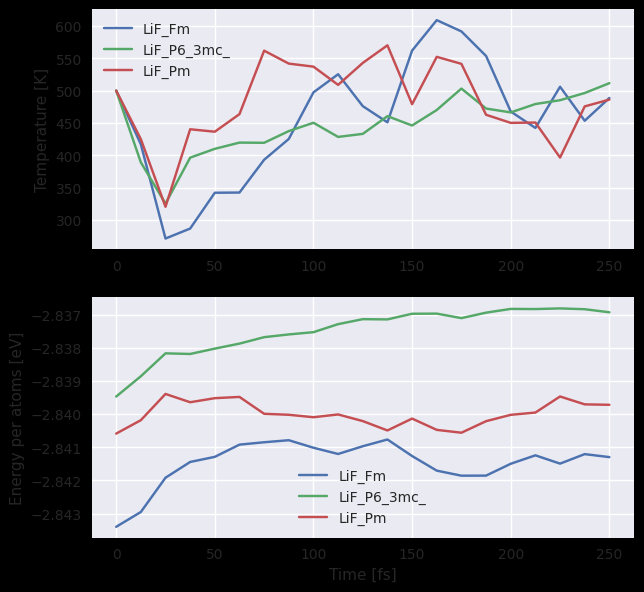

In [62]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    idx = np.arange(len(results_df.index))
    for sim in results_df.index:
        name = sim.split("-")[2]
        ax1.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_Temp"], label=name)
        ax2.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_energy_per_atom_t"], label=name)

    ax1.set_ylabel("Temperature [K]")
    ax2.set_ylabel("Energy per atoms [eV]")
    ax2.set_xlabel("Time [fs]")
    ax1.legend()
    ax2.legend()

plt.show()
fig.savefig(os.path.join("plots", f"11-{CHEM_FORMULA}_bulk_500K_MD.pdf"), dpi=300, bbox_inches="tight")

#### Save frames 

In [63]:
dir_jobs = os.path.join(RUN_DIR, "jobs")
conf_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11.1-bulk_500K_frames")
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

make_dir(conf_dir)
last_n_frames = 10
nskip = 2
frame_results_df = pd.DataFrame(columns=["step", "time", "unitcell_repetition"])

mols_ase = []

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    name = sim_name[3:]
    steps = job_result.get_history_property("Step")
    n_frame = len(steps)
    n_rep = results_df.loc[f"{name}.cif", "unitcell_repetition"]
    for i_frame in range(n_frame - last_n_frames * nskip + 1, n_frame, nskip):
        frame_name = f"{name}_{steps[i_frame] * TIMESTEP:1.1f}ps"
        mol = job.results.get_history_molecule(i_frame + 1)
        # print(os.path.join(conf_dir, f'{name}.cif'))
        mol = SCMtoASE(mol)
        mol.write(os.path.join(conf_dir, f"{frame_name}.cif"), format="cif")
        frame_results_df.loc[f"{frame_name}.cif", "unitcell_repetition"] = n_rep
        frame_results_df.loc[f"{frame_name}.cif", "step"] = steps[i_frame]
        frame_results_df.loc[f"{frame_name}.cif", "time"] = steps[i_frame] * TIMESTEP
        mols_ase.append(mol.copy())

frame_results_df.to_json(os.path.join(conf_dir, "info.json"))

[22:59:07] Job MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 reported warnings. Please check the the output
[22:59:07] Job MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 reported warnings. Please check the the output
[22:59:08] Job MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 reported warnings. Please check the the output


In [64]:
frame_results_df

,step,time,unitcell_repetition
11.0-0-LiF_Fm-3m_-3.18_2x2x3_25.0ps.cif,100,25,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_50.0ps.cif,200,50,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_75.0ps.cif,300,75,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_100.0ps.cif,400,100,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_125.0ps.cif,500,125,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_150.0ps.cif,600,150,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_175.0ps.cif,700,175,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_200.0ps.cif,800,200,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_225.0ps.cif,900,225,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_250.0ps.cif,1000,250,12


/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



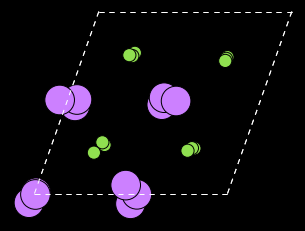

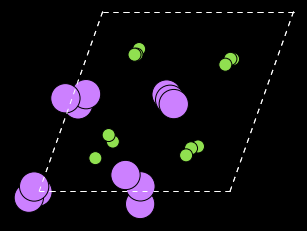

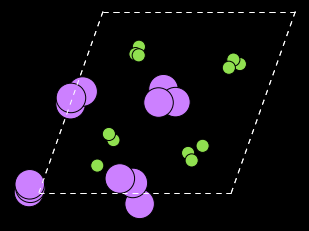

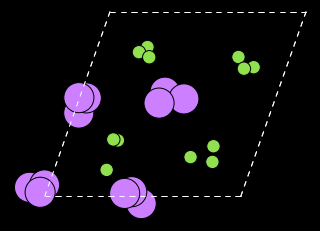

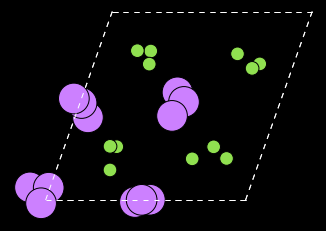

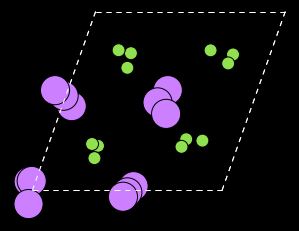

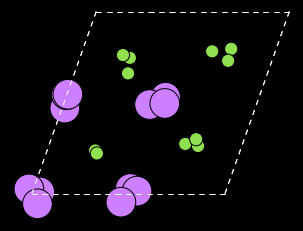

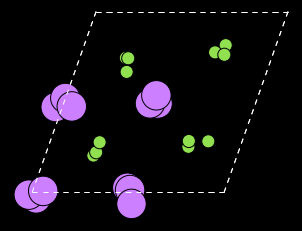

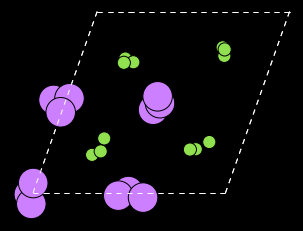

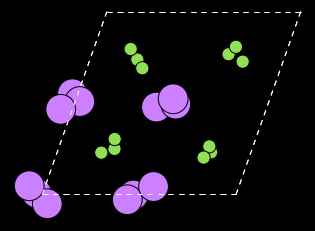

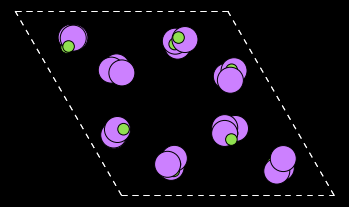

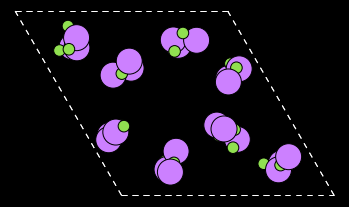

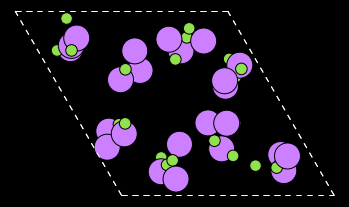

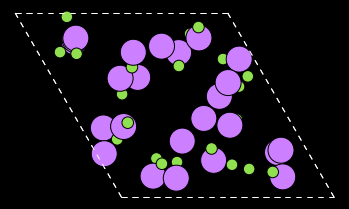

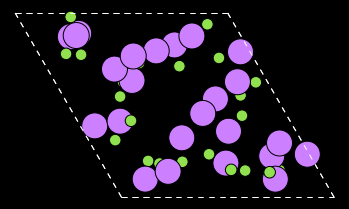

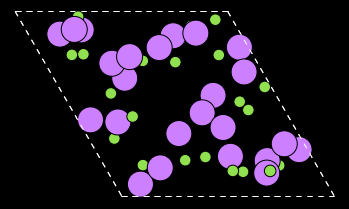

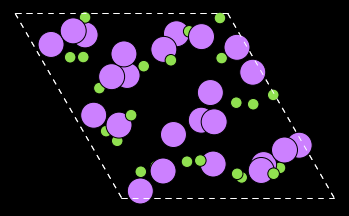

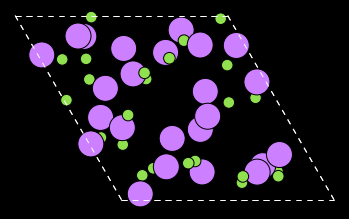

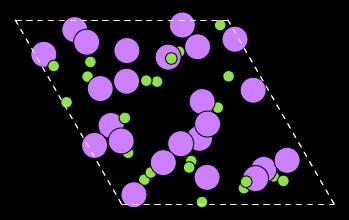

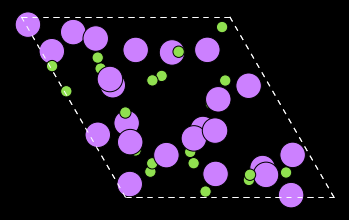

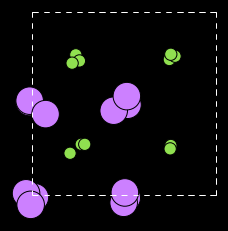

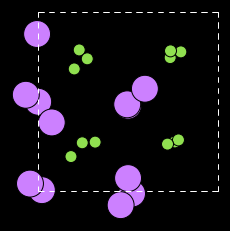

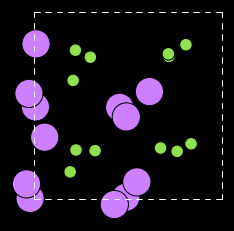

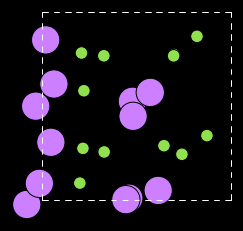

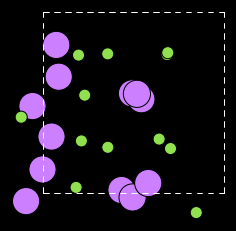

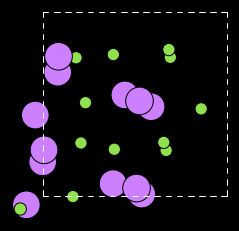

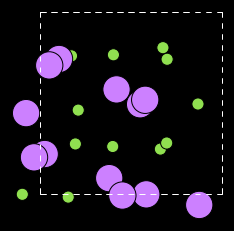

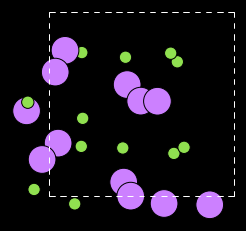

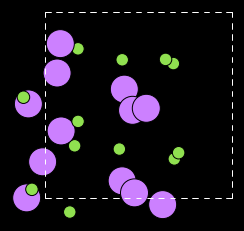

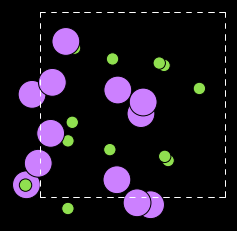

In [65]:
from ase.visualize.plot import plot_atoms

file_name = frame_results_df.index

for name, sys in zip(file_name, mols_ase):
    fig, ax = plt.subplots()
    plot_atoms(sys, ax, radii=0.3, rotation=("0x,0y,0z"))
    ax.set_axis_off()
    fig.savefig(os.path.join("plots", "sys-" + name[:-4] + ".pdf"), dpi=200)

In [ ]:
from ase.visualize import view

v = view(mols_ase, viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(Li2O_ase)
# v.view.add_unitcell(Li2O_ase)
# v.view.display(gui=False)
v

#### Finishing 

In [66]:
scm.finish()

### Bulk 500 K `Single Point`

In [67]:
SIMsNAME = "11.1-Bulk_500K_SP"

#### Setting `DFTB` *ab initio MD*

In [68]:
settings = scm.Settings()
settings.input.AMS.task = "SinglePoint"
settings.input.AMS.Properties.Gradients = "yes"
settings.input.AMS.Properties.StressTensor = "no"
settings.input.AMS.Properties.Hessian = "no"
settings.input.AMS.Properties.PESPointCharacter = "no"
settings.input.AMS.Properties.ElasticTensor = "no"
settings.input.AMS.GeometryOptimization.OptimizeLattice = "no"
# settings.input.ams.properties.normalmodes = 'Yes'
settings.input.BAND.basis.type = "DZP"  # DZP Double zeta polarized basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
# plus it can descrive the atom polarization since it add a p-function ()
settings.input.BAND.xc.GGA = "PBE"  # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
# (https://doi.org/10.1103/PhysRevLett.100.136406)
settings.input.BAND.xc.MetaGGA = "postscf TPSS"  # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
# TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)

#### Set-up `RUNNER`

In [69]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "SP"
NODES = 4
CORES_PER_NODE = 32
CPUS_PER_CORE = 4
MAX_JOBS = 64

In [70]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[23:00:10] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/11.1-Bulk_500K_SP


In [71]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [72]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '11.1-bulk_500K_frames')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASEystem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [73]:
# systems

Define jobs

In [74]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2021.104"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [75]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [76]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[23:00:37] JOB jobs STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_100.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_125.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_150.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_175.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_200.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_225.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_25.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_250.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_50.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_75.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_100.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_125.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_150.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_175.0ps STARTED
[23:00:37] JOB jobs

#### Post-processing

Move to end folder

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [ ]:
results_df

,unitcell_repetition
7.0-0-LiF_Fm-3m_-3.18_3x3x3.cif,27
7.0-1-LiF_P6_3mc_-3.17_3x3x3.cif,27
7.0-2-LiF_Pm-3m_-2.89_3x3x3.cif,27


In [ ]:
temp_df = pd.DataFrame(index=results_df.index, columns=["scm_step", "scm_Temp", "scm_energy_per_atom_t"])

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    Nentry = job_result.read_rkf_section("History")["nEntries"]
    energy = scm.Units.convert(
        job_result.read_rkf_section("History")[f"Energy({Nentry})"], "au", "eV"
    )  # scm.Units.convert(job_result.get_energy(), 'au', 'eV')
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    temp_df.at[sim_name[3:] + ".cif", "scm_step"] = np.array(job_result.get_history_property("Step"))
    temp_df.at[sim_name[3:] + ".cif", "scm_Temp"] = np.array(job_result.read_rkf_section("MDHistory")["Temperature(1)"])
    temp_df.at[sim_name[3:] + ".cif", "scm_energy_per_atom_t"] = (
        np.array(job_result.get_history_property("Energy")) / Na
    )

results_df = pd.concat([results_df, temp_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

In [ ]:
results_df

,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id,scm_step,scm_Temp,scm_energy_per_atom_t
7.0-0-LiF_Fm-3m_-3.18_3x3x3.cif,27,-4163.214306,-77.096561,0.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2600.0, 2227.472837617847, 1746.6540792818357...","[-2.844426643130874, -2.842366090997381, -2.83..."
7.0-1-LiF_P6_3mc_-3.17_3x3x3.cif,27,-8318.727662,-77.025256,1.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2600.0, 2201.8829583416705, 2011.420067554859...","[-2.8400756492875705, -2.837850360580547, -2.8..."
7.0-2-LiF_Pm-3m_-2.89_3x3x3.cif,27,-4162.027782,-77.074589,2.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2599.9999999999995, 2307.5056676702957, 1673....","[-2.8410294274160868, -2.8393977166355455, -2...."


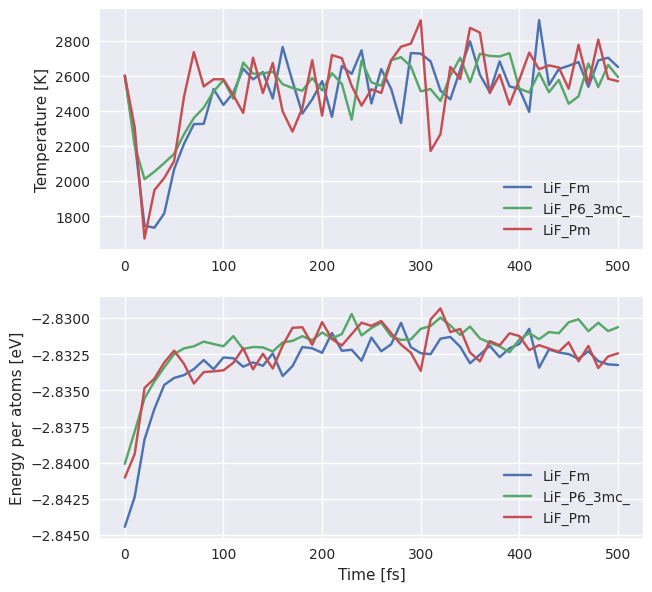

In [ ]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    idx = np.arange(len(results_df.index))
    for sim in results_df.index:
        name = sim.split("-")[2]
        ax1.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_Temp"], label=name)
        ax2.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_energy_per_atom_t"], label=name)

    ax1.set_ylabel("Temperature [K]")
    ax2.set_ylabel("Energy per atoms [eV]")
    ax2.set_xlabel("Time [fs]")
    ax1.legend()
    ax2.legend()

plt.show()
fig.savefig(os.path.join("plots", f"11.1-{CHEM_FORMULA}_bulk_500K.pdf"), dpi=300, bbox_inches="tight")

In [ ]:
scm.finish()

### Bulk 500K `ab initio MD`

In [55]:
SIMsNAME = "11-Bulk_500K_MD"

#### Setting `DFTB` *ab initio MD*

In [56]:
STEPS = 1000
TIMESTEP = 0.25  # [fs]
TEMP = 500
settings = scm.Settings()
settings.input.ams.task = "MolecularDynamics"
settings.input.ams.MolecularDynamics.NSteps = STEPS
settings.input.ams.MolecularDynamics.TimeStep = TIMESTEP
settings.input.ams.MolecularDynamics.Trajectory.PrintFreq = 5
settings.input.ams.MolecularDynamics.Trajectory.SamplingFreq = 50
# settings.input.ams.MolecularDynamics.Preserve.CenterOfMass = 'yes'
settings.input.ams.MolecularDynamics.InitialVelocities.Temperature = TEMP
settings.input.ams.MolecularDynamics.Thermostat.Type = "Berendsen"
settings.input.ams.MolecularDynamics.Thermostat.Temperature = TEMP
settings.input.ams.MolecularDynamics.Thermostat.Tau = int(100 * TIMESTEP)
# Engine
settings.input.DFTB.Model = "NonSCC-GFN1-xTB"
# settings.input.DFTB.SCC.Iterations = 500
# settings.input.DFTB.DispersionCorrection = 'Auto'

#### Set-up `RUNNER`

In [57]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "MD"
NODES = 1
CORES_PER_NODE = 128
CPUS_PER_CORE = 2
MAX_JOBS = 0

In [7]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[12:36:29] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/11-Bulk_500K_MD


In [8]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [9]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, '11-bulk_500K')
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split('.cif')[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASEsystem_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [10]:
systems

[('11.0-0-LiF_Fm-3m_-3.18_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fac99a34518>),
 ('11.0-1-LiF_P6_3mc_-3.17_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fac99a38a20>),
 ('11.0-2-LiF_Pm-3m_-2.89_2x2x3',
  <scm.plams.mol.molecule.Molecule at 0x7fa9d2f15b70>)]

Define jobs

In [11]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2022.102"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [12]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [ ]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[12:36:49] JOB jobs STARTED
[12:36:49] JOB jobs/MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 STARTED
[12:36:49] JOB jobs/MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 STARTED
[12:36:49] JOB jobs/MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 STARTED


#### Post-processing

Move to end folder

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [58]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [59]:
results_df

,unitcell_repetition
11.0-0-LiF_Fm-3m_-3.18_2x2x3.cif,12
11.0-1-LiF_P6_3mc_-3.17_2x2x3.cif,12
11.0-2-LiF_Pm-3m_-2.89_2x2x3.cif,12


In [60]:
temp_df = pd.DataFrame(index=results_df.index, columns=["scm_step", "scm_Temp", "scm_energy_per_atom_t"])

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    Nentry = job_result.read_rkf_section("History")["nEntries"]
    energy = scm.Units.convert(
        job_result.read_rkf_section("History")[f"Energy({Nentry})"], "au", "eV"
    )  # scm.Units.convert(job_result.get_energy(), 'au', 'eV')
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    temp_df.at[sim_name[3:] + ".cif", "scm_step"] = np.array(job_result.get_history_property("Step"))
    temp_df.at[sim_name[3:] + ".cif", "scm_Temp"] = np.array(job_result.read_rkf_section("MDHistory")["Temperature(1)"])
    temp_df.at[sim_name[3:] + ".cif", "scm_energy_per_atom_t"] = (
        np.array(job_result.get_history_property("Energy")) / Na
    )

results_df = pd.concat([results_df, temp_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

[22:58:56] Job MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 reported warnings. Please check the the output
[22:58:56] Job MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 reported warnings. Please check the the output
[22:58:56] Job MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 reported warnings. Please check the the output


In [61]:
results_df

,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id,scm_step,scm_Temp,scm_energy_per_atom_t
11.0-0-LiF_Fm-3m_-3.18_2x2x3.cif,12,-1855.574178,-77.315591,0.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[499.9999999999999, 416.923323063444, 271.1582...","[-2.8434003513590658, -2.842952894535068, -2.8..."
11.0-1-LiF_P6_3mc_-3.17_2x2x3.cif,12,-3705.435048,-77.196564,1.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[499.9999999999999, 389.0072525130963, 325.165...","[-2.8394662073566574, -2.8388537012790294, -2...."
11.0-2-LiF_Pm-3m_-2.89_2x2x3.cif,12,-1854.542496,-77.272604,2.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[500.0, 424.927725103416, 320.27012569595587, ...","[-2.8405855542363496, -2.8401801382610117, -2...."


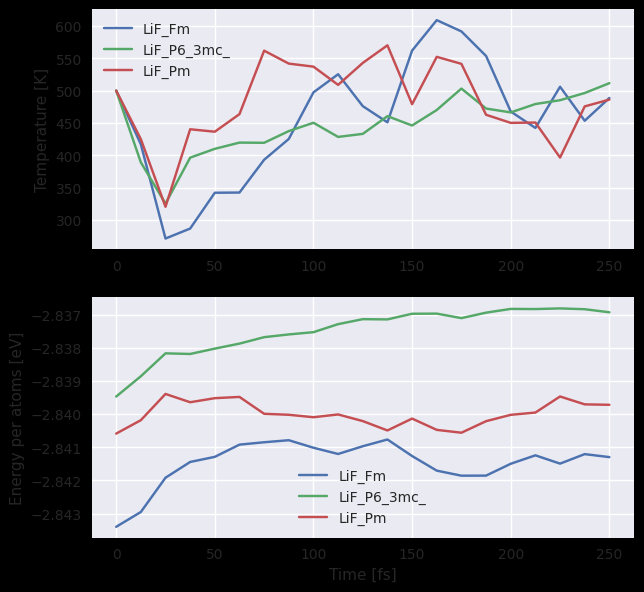

In [62]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    idx = np.arange(len(results_df.index))
    for sim in results_df.index:
        name = sim.split("-")[2]
        ax1.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_Temp"], label=name)
        ax2.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_energy_per_atom_t"], label=name)

    ax1.set_ylabel("Temperature [K]")
    ax2.set_ylabel("Energy per atoms [eV]")
    ax2.set_xlabel("Time [fs]")
    ax1.legend()
    ax2.legend()

plt.show()
fig.savefig(os.path.join("plots", f"11-{CHEM_FORMULA}_bulk_500K_MD.pdf"), dpi=300, bbox_inches="tight")

#### Save frames 

In [63]:
dir_jobs = os.path.join(RUN_DIR, "jobs")
conf_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11.1-bulk_500K_frames")
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
results_df = pd.read_json(data_path)

make_dir(conf_dir)
last_n_frames = 10
nskip = 2
frame_results_df = pd.DataFrame(columns=["step", "time", "unitcell_repetition"])

mols_ase = []

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    name = sim_name[3:]
    steps = job_result.get_history_property("Step")
    n_frame = len(steps)
    n_rep = results_df.loc[f"{name}.cif", "unitcell_repetition"]
    for i_frame in range(n_frame - last_n_frames * nskip + 1, n_frame, nskip):
        frame_name = f"{name}_{steps[i_frame] * TIMESTEP:1.1f}ps"
        mol = job.results.get_history_molecule(i_frame + 1)
        # print(os.path.join(conf_dir, f'{name}.cif'))
        mol = SCMtoASE(mol)
        mol.write(os.path.join(conf_dir, f"{frame_name}.cif"), format="cif")
        frame_results_df.loc[f"{frame_name}.cif", "unitcell_repetition"] = n_rep
        frame_results_df.loc[f"{frame_name}.cif", "step"] = steps[i_frame]
        frame_results_df.loc[f"{frame_name}.cif", "time"] = steps[i_frame] * TIMESTEP
        mols_ase.append(mol.copy())

frame_results_df.to_json(os.path.join(conf_dir, "info.json"))

[22:59:07] Job MD-11.0-0-LiF_Fm-3m_-3.18_2x2x3 reported warnings. Please check the the output
[22:59:07] Job MD-11.0-1-LiF_P6_3mc_-3.17_2x2x3 reported warnings. Please check the the output
[22:59:08] Job MD-11.0-2-LiF_Pm-3m_-2.89_2x2x3 reported warnings. Please check the the output


In [64]:
frame_results_df

,step,time,unitcell_repetition
11.0-0-LiF_Fm-3m_-3.18_2x2x3_25.0ps.cif,100,25,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_50.0ps.cif,200,50,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_75.0ps.cif,300,75,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_100.0ps.cif,400,100,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_125.0ps.cif,500,125,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_150.0ps.cif,600,150,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_175.0ps.cif,700,175,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_200.0ps.cif,800,200,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_225.0ps.cif,900,225,12
11.0-0-LiF_Fm-3m_-3.18_2x2x3_250.0ps.cif,1000,250,12


/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



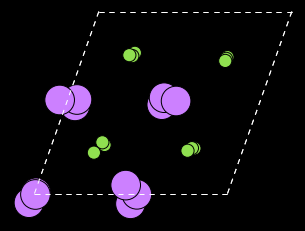

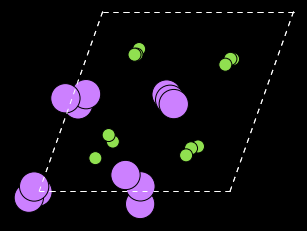

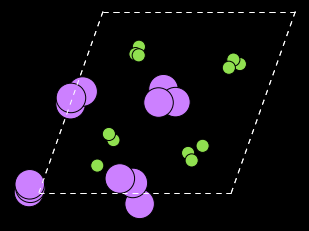

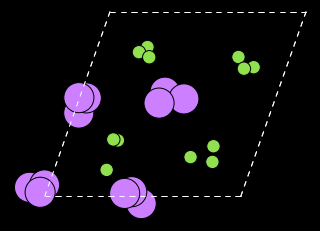

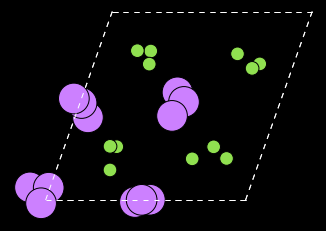

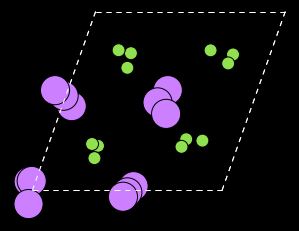

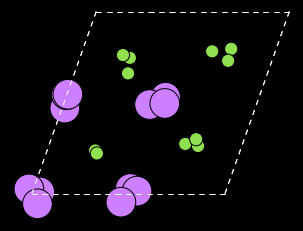

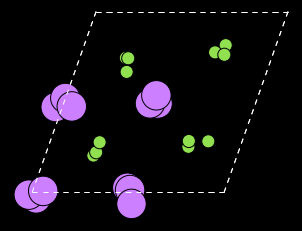

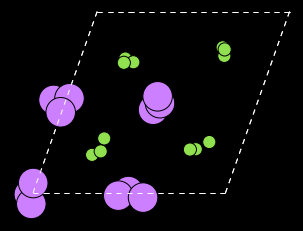

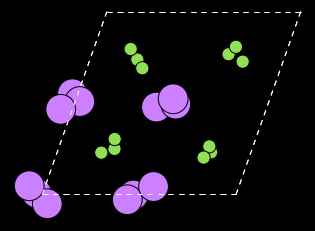

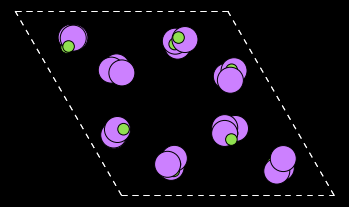

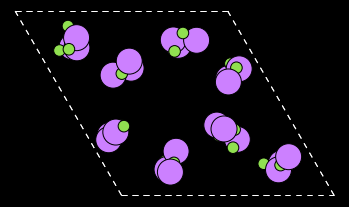

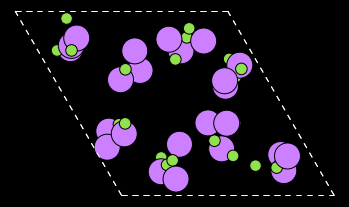

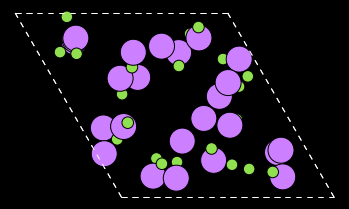

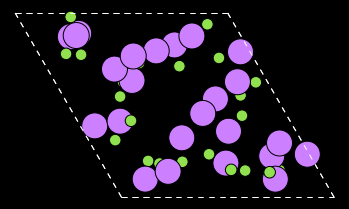

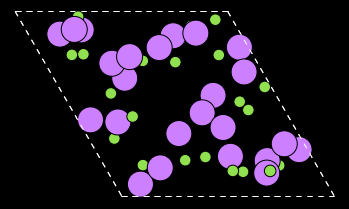

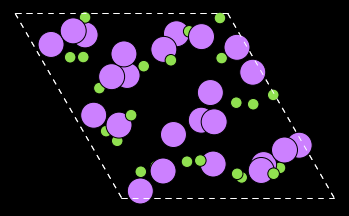

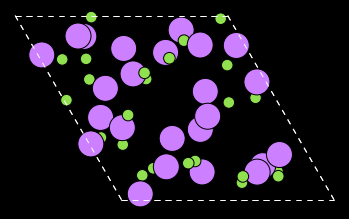

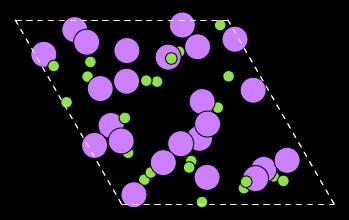

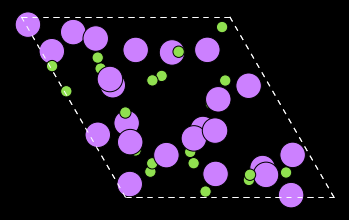

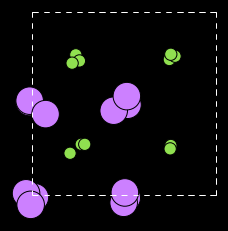

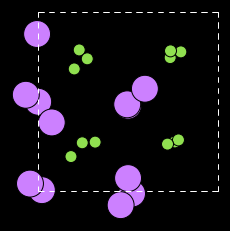

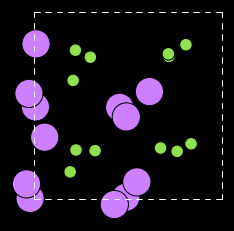

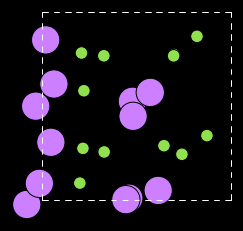

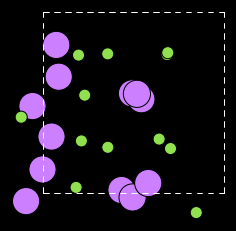

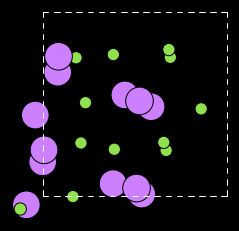

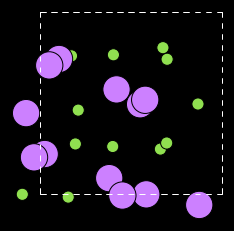

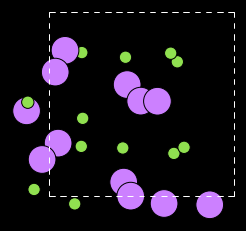

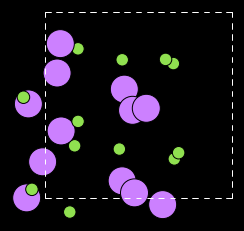

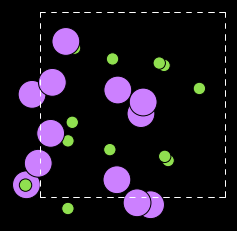

In [65]:
from ase.visualize.plot import plot_atoms

file_name = frame_results_df.index

for name, sys in zip(file_name, mols_ase):
    fig, ax = plt.subplots()
    plot_atoms(sys, ax, radii=0.3, rotation=("0x,0y,0z"))
    ax.set_axis_off()
    fig.savefig(os.path.join("plots", "sys-" + name[:-4] + ".pdf"), dpi=200)

In [ ]:
from ase.visualize import view

v = view(mols_ase, viewer="ngl")
# v.view.clear()
# v.view.add_ball_and_stick(Li2O_ase)
# v.view.add_unitcell(Li2O_ase)
# v.view.display(gui=False)
v

#### Finishing 

In [66]:
scm.finish()

### Bulk 500 K `Single Point`

In [67]:
SIMsNAME = "11.1-Bulk_500K_SP"

#### Setting `DFTB` *ab initio MD*

In [68]:
settings = scm.Settings()
settings.input.AMS.task = "SinglePoint"
settings.input.AMS.Properties.Gradients = "yes"
settings.input.AMS.Properties.StressTensor = "no"
settings.input.AMS.Properties.Hessian = "no"
settings.input.AMS.Properties.PESPointCharacter = "no"
settings.input.AMS.Properties.ElasticTensor = "no"
settings.input.AMS.GeometryOptimization.OptimizeLattice = "no"
# settings.input.ams.properties.normalmodes = 'Yes'
settings.input.BAND.basis.type = "DZP"  # DZP Double zeta polarized basis.
# This type of basis sets is thus far provided only for the elements up to Kr (valence e in p-orbital d-orbital)
# Slater-type orbitals (STOs) orbital, with 3 "zeta" parametars to better descrive the electron dispersion (r>>r0)
# plus it can descrive the atom polarization since it add a p-function ()
settings.input.BAND.xc.GGA = "PBE"  # Perdew-Burke-Ernzerhof (1996) Exchange-and-correlation (XC) functional
# (https://doi.org/10.1103/PhysRevLett.100.136406)
settings.input.BAND.xc.MetaGGA = "postscf TPSS"  # A meta-GGA DFT functional in its original form includes the second derivative of the electron density
# TPSS: The 2003 meta-GGA (https://doi.org/10.1103/PhysRevLett.91.146401)

#### Set-up `RUNNER`

In [69]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, SIMsNAME)
TASK = "SP"
NODES = 4
CORES_PER_NODE = 32
CPUS_PER_CORE = 4
MAX_JOBS = 64

In [70]:
scm.init(folder=RUN_DIR)
RUNNER = scm.GridRunner(grid="slurm", sleepstep=5, parallel=True, maxjobs=MAX_JOBS)  # TODO: Replace it with GridRunner
RUNNER.settings.workdir = "-D"
RUNNER.settings.special.nodes = "--nodes="
RUNNER.settings.special.qos = "--qos="
RUNNER.settings.special.walltime = "--time="
RUNNER.settings.special.tasks_per_node = "--ntasks-per-node="
RUNNER.settings.special.cpus_per_task = "--cpus-per-task="
RUNNER.settings.special.partition = "--partition="
RUNNER.settings.special.account = "--account="
RUNNER.settings.special.job_name = "--job-name="

scm.config.log.file = 7  # debug
scm.config.log.stdout = 1  # 1: important 3: normal 5: verbose 7: debug
scm.config.job.pickle = False
scm.config.job.runscript.nproc = CORES_PER_NODE
scm.config.job.runscript.shebang = "#!/bin/bash"
scm.config.default_jobrunner = RUNNER

[23:00:10] PLAMS working folder: /mnt/lustre/a2fs-work3/work/pr1u1751/pr1u1751/pr1id026/BATTERY/AMS_ReaxFF/trainset_sim/11.1-Bulk_500K_SP


In [71]:
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "wb") as file:
    pickle.dump(settings, file)

#### Set-up JOBS

Load systems

In [72]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11.1-bulk_500K_frames")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, fromASE(system_ase)))

/work/pr1u1751/pr1u1751/pr1id026/venv_ams/AMS2021.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [73]:
# systems

Define jobs

In [74]:
jobs = []
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    job = scm.AMSJob(molecule=system_obj, settings=settings, name=sim_name)
    job.settings.runscript.pre = """module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2021.104"""
    jobs.append(job)
# Group all
multi_jobs = scm.MultiJob(name="jobs", children=jobs)

In [75]:
# for i, job_ in enumerate(jobs):
#     job_.run(jobrunner=RUNNER, nodes=NODES, cores=CORES_PER_NODE*NODES, tasks_per_node=CORES_PER_NODE,
#             walltime='24:00:00', partition='standard', account='pr1u1751',
#             qos='standard', job_name=f'{i}-{SIMsNAME}', watch=True)

#### Run All

In [76]:
result = multi_jobs.run(
    jobrunner=RUNNER,
    nodes=NODES,
    cores=CORES_PER_NODE * NODES,
    tasks_per_node=CORES_PER_NODE,
    cpus_per_task=CPUS_PER_CORE,
    walltime="24:00:00",
    partition="standard",
    account="pr1u1751",
    qos="standard",
)

[23:00:37] JOB jobs STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_100.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_125.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_150.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_175.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_200.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_225.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_25.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_250.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_50.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-0-LiF_Fm-3m_-3.18_2x2x3_75.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_100.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_125.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_150.0ps STARTED
[23:00:37] JOB jobs/SP-11.0-1-LiF_P6_3mc_-3.17_2x2x3_175.0ps STARTED
[23:00:37] JOB jobs

#### Post-processing

Move to end folder

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    # copy inputs
    for src_file in glob.glob(os.path.join(job_dir, f"{sim_name}.*")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(ALLSIM_DIR, file_name)
        copyfile(src_file, dst_file)
    # copy and rename log file
    src_file = os.path.join(job_dir, "ams.log")
    dst_file = os.path.join(ALLSIM_DIR, f"{sim_name}.log")
    # copy and store in folder the results
    results_dir = os.path.join(ALLSIM_DIR, f"{sim_name}.results")
    make_dir(results_dir)
    for src_file in glob.glob(os.path.join(job_dir, "*.rkf")):
        file_name = src_file.split(os.sep)[-1]
        dst_file = os.path.join(results_dir, file_name)
        copyfile(src_file, dst_file)

Post Processing

Load Material Project data

In [ ]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "11-bulk_500K")
data_path = os.path.join(cis_dir, "info.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
results_df = pd.read_json(data_path)

In [ ]:
results_df

,unitcell_repetition
7.0-0-LiF_Fm-3m_-3.18_3x3x3.cif,27
7.0-1-LiF_P6_3mc_-3.17_3x3x3.cif,27
7.0-2-LiF_Pm-3m_-2.89_3x3x3.cif,27


In [ ]:
temp_df = pd.DataFrame(index=results_df.index, columns=["scm_step", "scm_Temp", "scm_energy_per_atom_t"])

for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    Nentry = job_result.read_rkf_section("History")["nEntries"]
    energy = scm.Units.convert(
        job_result.read_rkf_section("History")[f"Energy({Nentry})"], "au", "eV"
    )  # scm.Units.convert(job_result.get_energy(), 'au', 'eV')
    results_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    results_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    results_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    temp_df.at[sim_name[3:] + ".cif", "scm_step"] = np.array(job_result.get_history_property("Step"))
    temp_df.at[sim_name[3:] + ".cif", "scm_Temp"] = np.array(job_result.read_rkf_section("MDHistory")["Temperature(1)"])
    temp_df.at[sim_name[3:] + ".cif", "scm_energy_per_atom_t"] = (
        np.array(job_result.get_history_property("Energy")) / Na
    )

results_df = pd.concat([results_df, temp_df], axis=1)
results_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

In [ ]:
results_df

,unitcell_repetition,scm_energy,scm_energy_per_atom,system_id,scm_step,scm_Temp,scm_energy_per_atom_t
7.0-0-LiF_Fm-3m_-3.18_3x3x3.cif,27,-4163.214306,-77.096561,0.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2600.0, 2227.472837617847, 1746.6540792818357...","[-2.844426643130874, -2.842366090997381, -2.83..."
7.0-1-LiF_P6_3mc_-3.17_3x3x3.cif,27,-8318.727662,-77.025256,1.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2600.0, 2201.8829583416705, 2011.420067554859...","[-2.8400756492875705, -2.837850360580547, -2.8..."
7.0-2-LiF_Pm-3m_-2.89_3x3x3.cif,27,-4162.027782,-77.074589,2.0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...","[2599.9999999999995, 2307.5056676702957, 1673....","[-2.8410294274160868, -2.8393977166355455, -2...."


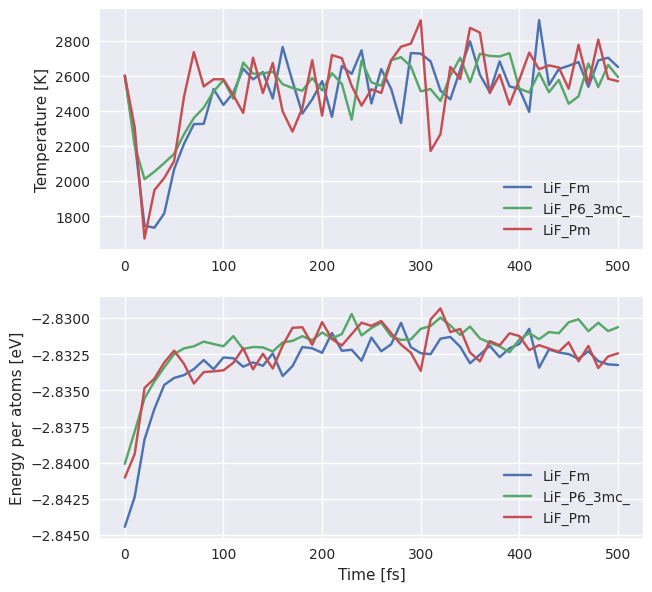

In [ ]:
fig = plt.figure(figsize=[7, 7], dpi=100)

with plt.style.context("./articles_seaborn.mplstyle"):
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    idx = np.arange(len(results_df.index))
    for sim in results_df.index:
        name = sim.split("-")[2]
        ax1.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_Temp"], label=name)
        ax2.plot(results_df.loc[sim, "scm_step"] * TIMESTEP, results_df.loc[sim, "scm_energy_per_atom_t"], label=name)

    ax1.set_ylabel("Temperature [K]")
    ax2.set_ylabel("Energy per atoms [eV]")
    ax2.set_xlabel("Time [fs]")
    ax1.legend()
    ax2.legend()

plt.show()
fig.savefig(os.path.join("plots", f"11.1-{CHEM_FORMULA}_bulk_500K.pdf"), dpi=300, bbox_inches="tight")

In [ ]:
scm.finish()